In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
from scipy.stats import norm
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import json
import ast
from PIL import Image
import time
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.model_selection import GridSearchCV
from paramsearch import paramsearch

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print(train.shape, test.shape)

(3000, 23) (4398, 22)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

### Attribute Explanation

**Data Description id** - Integer unique id of each movie

**belongs_to_collection** - Contains the TMDB Id, Name, Movie Poster and Backdrop URL of a movie in JSON format. You can see the Poster and Backdrop Image like this: https://image.tmdb.org/t/p/original/. Example: https://image.tmdb.org/t/p/original//iEhb00TGPucF0b4joM1ieyY026U.jpg

**budget** - Budget of a movie in dollars. 0 values mean unknown.

**genres** - Contains all the Genres Name & TMDB Id in JSON Format

**homepage** - Contains the official homepage URL of a movie. Example: http://sonyclassics.com/whiplash/ , this is the homepage of Whiplash movie.

**imdb_id** - IMDB id of a movie (string). You can visit the IMDB Page like this: https://www.imdb.com/title/

**original_language** - Two digit code of the original language, in which the movie was made. Like: en = English, fr = french.

**original_title** - The original title of a movie. Title & Original title may differ, if the original title is not in English.

**overview** - Brief description of the movie.

**popularity** - Popularity of the movie in float.

**poster_path** - Poster path of a movie. You can see the full image like this: https://image.tmdb.org/t/p/original/

**production_companies** - All production company name and TMDB id in JSON format of a movie.

**production_countries** - Two digit code and full name of the production company in JSON format.

**release_date** - Release date of a movie in mm/dd/yy format.

**runtime** - Total runtime of a movie in minutes (Integer).

**spoken_languages** - Two digit code and full name of the spoken language.

**status** - Is the movie released or rumored?

**tagline** - Tagline of a movie

**title** - English title of a movie

**Keywords** - TMDB Id and name of all the keywords in JSON format.

**cast** - All cast TMDB id, name, character name, gender (1 = Female, 2 = Male) in JSON format

**crew** - Name, TMDB id, profile path of various kind of crew members job like Director, Writer, Art, Sound etc.

**revenue** - Total revenue earned by a movie in dollars.

#### Data Exploration

In [3]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [101]:
train.isna().sum().sort_values(ascending = False)

belongs_to_collection    2396
homepage                 2054
tagline                   597
Keywords                  276
production_companies      156
production_countries       55
spoken_languages           20
crew                       16
cast                       13
overview                    8
genres                      7
runtime                     2
poster_path                 1
original_language           0
budget                      0
imdb_id                     0
revenue                     0
original_title              0
popularity                  0
release_date                0
status                      0
title                       0
id                          0
dtype: int64

In [102]:
test.isna().sum().sort_values(ascending = False)

belongs_to_collection    3521
homepage                 2978
tagline                   863
Keywords                  393
production_companies      258
production_countries      102
spoken_languages           42
crew                       22
genres                     16
overview                   14
cast                       13
runtime                     4
title                       3
status                      2
poster_path                 1
release_date                1
original_language           0
imdb_id                     0
original_title              0
popularity                  0
budget                      0
id                          0
dtype: int64

In [14]:
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


In [35]:
test.describe()

,id,budget,popularity,runtime
count,4398.000000,4.398000e+03,4398.000000,4394.000000
mean,5199.500000,2.264929e+07,8.550230,107.622212
std,1269.737571,3.689991e+07,12.209014,21.058290
min,3001.000000,0.000000e+00,0.000001,0.000000
25%,4100.250000,0.000000e+00,3.895186,94.000000
50%,5199.500000,7.450000e+06,7.482241,104.000000
75%,6298.750000,2.800000e+07,10.938524,118.000000
max,7398.000000,2.600000e+08,547.488298,320.000000


**Clean Data - Budget, Revenue, Runtime**

There are several instances where the budget, revenue and runtime figures are not available or have very low values (possibly units changed). 

Budget - More than 800 records have zero values for Budget. These are replaced by median budget in train and test sets. For single digit budget figures, which possibly indicate budget in millions, we multiply the figure with 1000000. 

In [3]:
#Budget replace zero values with median budget
train_budget_median = train['budget'].median()
train.loc[train['budget'] == 0, 'budget'] = train_budget_median

test_budget_median = test['budget'].median()
test.loc[test['budget'] == 0, 'budget'] = test_budget_median

#Budget replace single-digit values with values multiplied by 1000000
train.loc[train['budget'] < 10, 'budget'] = train.loc[train['budget'] < 10, 'budget']*1000000

test.loc[test['budget'] < 10, 'budget'] = test.loc[test['budget'] < 10, 'budget']*1000000


We next fix the revenue figures which are abnormally low by multiplying the figure by 100000

In [4]:
power_six = train.id[train.budget > 1000][train.revenue < 100]

for k in power_six :
    train.loc[train['id'] == k,'revenue'] =  train.loc[train['id'] == k,'revenue'] * 100000
    

For films with zero or 'nan' runtime we replace the values with median runtime values

In [5]:
#Runtime
train_runtime_median = train['runtime'].median(skipna = True)
train.loc[train['runtime'] == 0, 'runtime'] = train_runtime_median
train['runtime'] = train.runtime.fillna(train_runtime_median)

test_runtime_median = test['runtime'].median(skipna = True)
test.loc[test['runtime'] == 0, 'runtime'] = test_runtime_median
test['runtime'] = test.runtime.fillna(test_runtime_median)


#### Revenue (Target Variable) Distribution

In [43]:
train['log_revenue'] = np.log1p(train['revenue'])

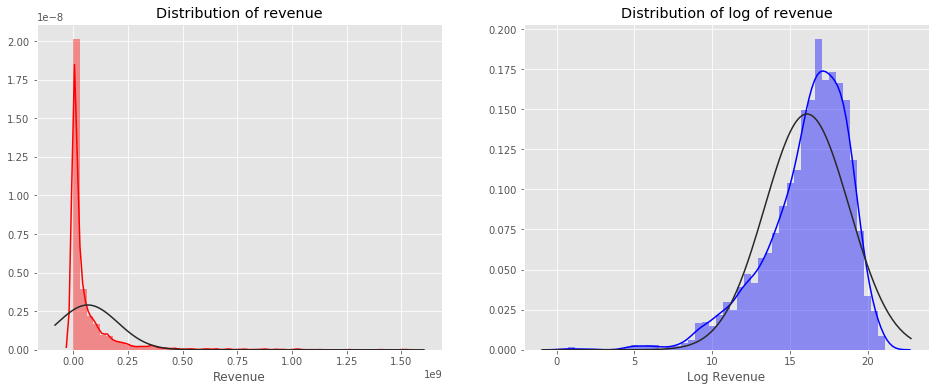

In [7]:
warnings.simplefilter('ignore')
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
sns.distplot(train['revenue'], fit = norm, color = 'red');
plt.xlabel("Revenue")
plt.title('Distribution of revenue');
plt.subplot(1, 2, 2)
sns.distplot(train['log_revenue'], fit = norm, color = 'blue');
plt.xlabel("Log Revenue")
plt.title('Distribution of log of revenue');

We can see that the distribution of revenue is quite skewed. The distribution of log revenues is more normalized and will be used as the target variable for modelling.

#### Relationship of target variable with other numeric columns - budget, popularity, runtime

#### Budget

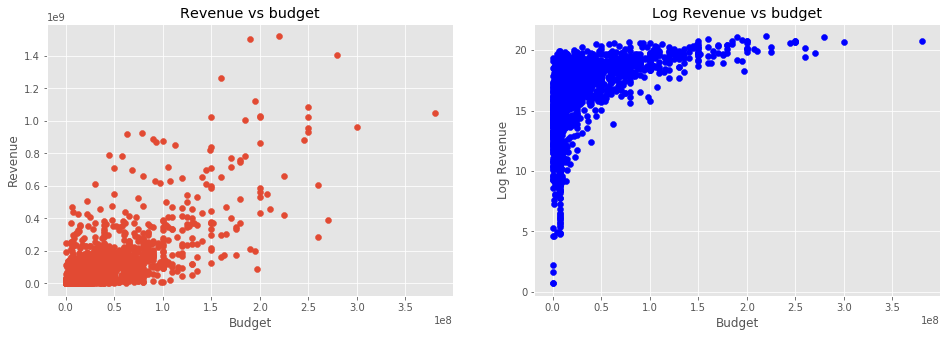

In [8]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.scatter(train['budget'], train['revenue'])
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.title('Revenue vs budget');
plt.subplot(1, 2, 2)
plt.scatter(train['budget'], train['log_revenue'], color = 'blue')
plt.xlabel("Budget")
plt.ylabel("Log Revenue")
plt.title('Log Revenue vs budget');


We can see that budget and revenue are somewhat correlated

#### Popularity

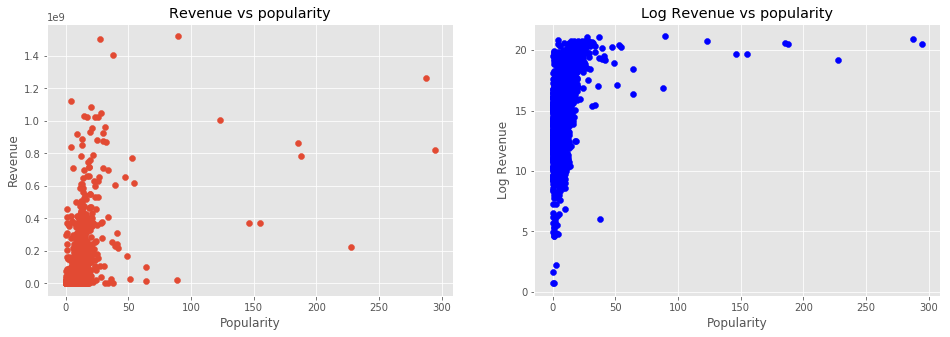

In [9]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.scatter(train['popularity'], train['revenue'])
plt.xlabel('Popularity')
plt.ylabel('Revenue')
plt.title('Revenue vs popularity');
plt.subplot(1, 2, 2)
plt.scatter(train['popularity'], train['log_revenue'], color = 'blue')
plt.xlabel('Popularity')
plt.ylabel('Log Revenue')
plt.title('Log Revenue vs popularity');

Not much correlation of popularity measure with target

#### Runtime - the length of the film in minutes

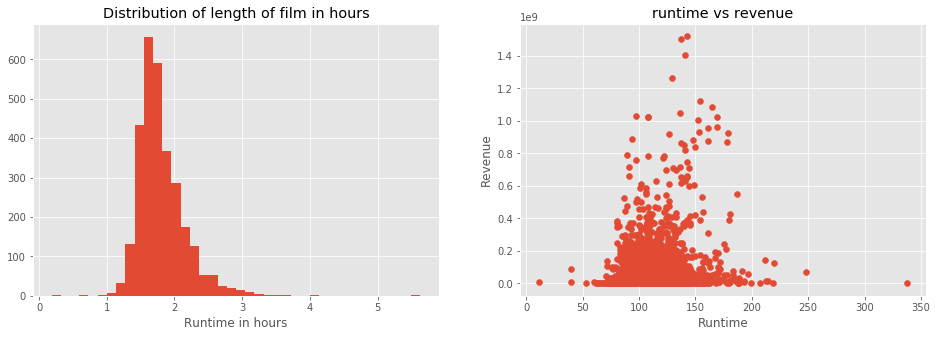

In [10]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.hist(train['runtime'].fillna(0) / 60, bins=40);
plt.xlabel('Runtime in hours')
plt.title('Distribution of length of film in hours');
plt.subplot(1, 2, 2)
plt.scatter(train['runtime'].fillna(0), train['revenue'])
plt.xlabel('Runtime')
plt.ylabel('Revenue')
plt.title('runtime vs revenue');


It seems that most of the films are 1.5-2 hour long and films with the highest revenue are also in this range

#### Date preprocessing to extract month, day, year, weekday, quarter from release date

Only the last two digits of the year are provided in release date. We use the function below to convert all years to 4 digit years either in the 20th or 21st century.

In [6]:
def fix_date(x):
    """
    Fixes dates which are have two-digit values for years
    """
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year
    

In [7]:
# Fill in missing value for release date of movie 'Jails, Hospitals & Hip-Hop' in test set based on publicly available release date in USA. 
test.loc[test['release_date'].isnull() == True, 'release_date'] = '20/03/01'


In [9]:
train['release_date'] = train['release_date'].apply(lambda x: fix_date(x))
test['release_date'] = test['release_date'].apply(lambda x: fix_date(x))
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

In [10]:
train['release_year'] = train['release_date'].dt.year
train['release_month'] = train['release_date'].dt.month
train['release_day'] = train['release_date'].dt.day
train['release_weekday'] = train['release_date'].dt.weekday
train['release_quarter'] = train['release_date'].dt.quarter

test['release_year'] = test['release_date'].dt.year
test['release_month'] = test['release_date'].dt.month
test['release_day'] = test['release_date'].dt.day
test['release_weekday'] = test['release_date'].dt.weekday
test['release_quarter'] = test['release_date'].dt.quarter

train = train.drop('release_date', axis = 1)
test = test.drop('release_date', axis = 1)


#### Relationship of revenue with release year, month, weekday,etc.

In [11]:
d1 = train['release_year'].value_counts().sort_index()
d2 = train.groupby(['release_year'])['revenue'].sum()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='total revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and total revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Total revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

We can see that number of films and total revenue are growing, which is to be expected. 

Text(0,0.5,'Total Revenue')

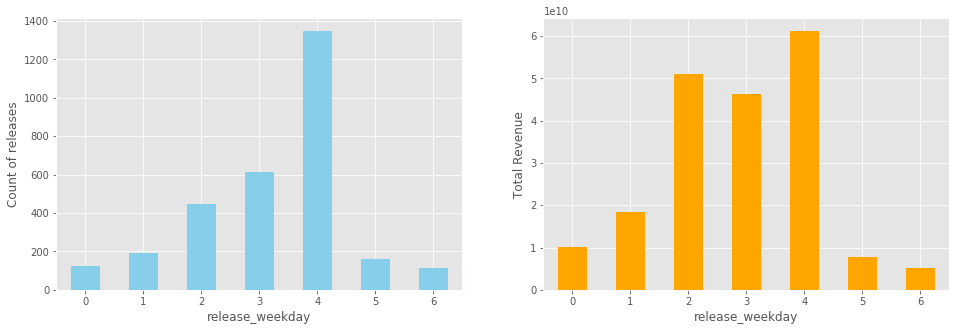

In [16]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
train.groupby('release_weekday').size().plot(kind='bar', color = 'skyblue',rot=0)
plt.ylabel('Count of releases')
plt.subplot(1, 2, 2)
train.groupby('release_weekday').agg('sum')['revenue'].plot(kind='bar', color = 'orange',rot=0)
plt.ylabel('Total Revenue')


Most movies are released on Fridays and thus have the highest total revenues as well.

Text(0,0.5,'Total Revenue')

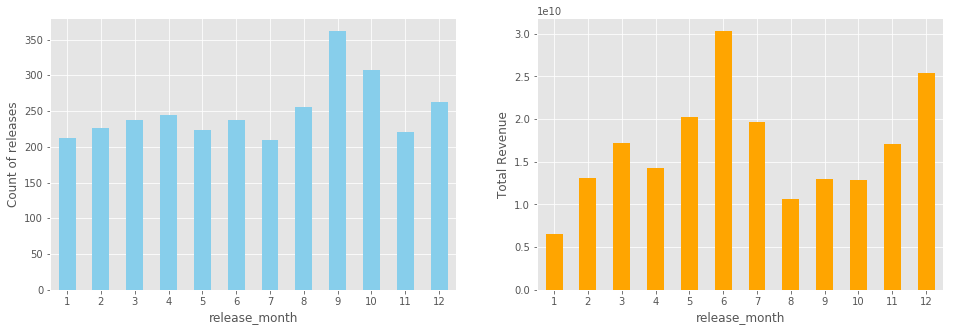

In [17]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
train.groupby('release_month').size().plot(kind='bar', color = 'skyblue',rot=0)
plt.ylabel('Count of releases')
plt.subplot(1,2,2)
train.groupby('release_month').agg('sum')['revenue'].plot(kind='bar',color='orange',rot=0)
plt.ylabel('Total Revenue')

More movies are released in September and October but movies released in the month of June have the highest total revenue followed by those in December

Text(0,0.5,'Total Revenue')

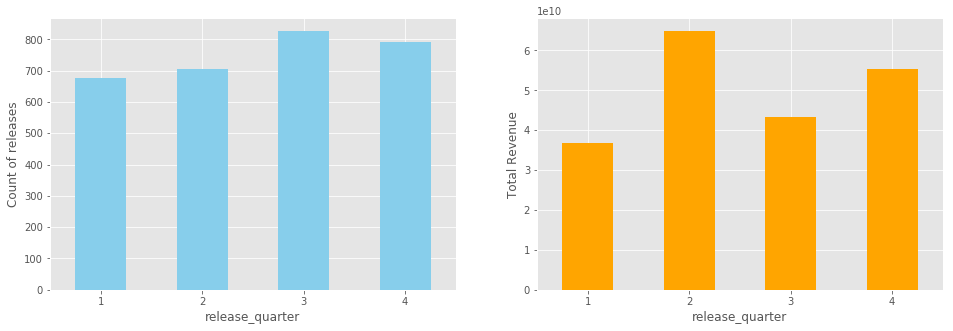

In [18]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
train.groupby('release_quarter').size().plot(kind='bar', color = 'skyblue',rot=0)
plt.ylabel('Count of releases')
plt.subplot(1,2,2)
train.groupby('release_quarter').agg('sum')['revenue'].plot(kind='bar', color = 'orange',rot=0)
plt.ylabel('Total Revenue')

Movies released in the second and last quarters have highest total revenue

**Correlation plot of numerical and date variables examined so far**

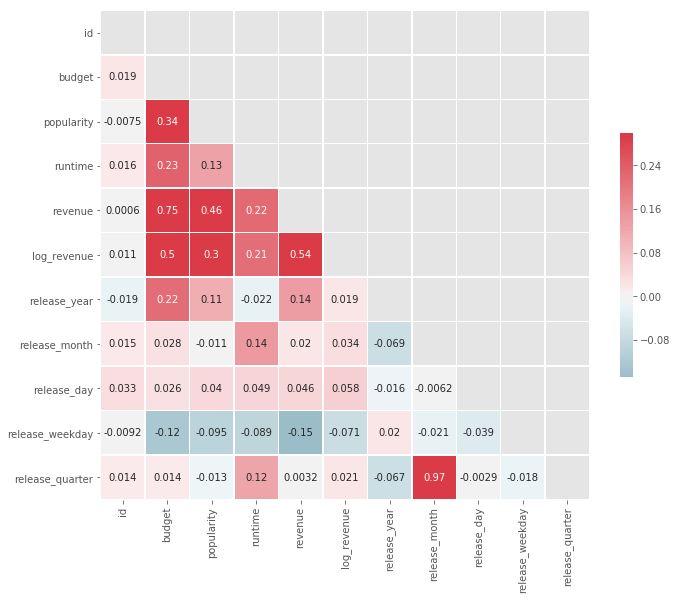

In [19]:
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Budget, popularity, runtime and to a lesser extent release year seem the variables most correlated with revenue and log revenue.

#### Feature extraction and EDA from JSON Format columns

In [12]:
# Preprocess columns to dictionary format
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train = text_to_dict(train)
test = text_to_dict(test)

#### Belongs_to_collection


In [22]:
for i, e in enumerate(train['belongs_to_collection'][:5]):
    print(i, e)

0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 {}
3 {}
4 {}


In [23]:
train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()


0    2396
1     604
Name: belongs_to_collection, dtype: int64

2396 values in this column are empty. A useful feature can be whether a movie belongs to a collection or not.

In [13]:
#train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

#test['collection_name'] = test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
test['has_collection'] = test['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

train = train.drop(['belongs_to_collection'], axis=1)
test = test.drop(['belongs_to_collection'], axis=1)

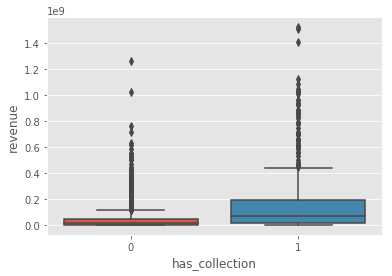

In [14]:
sns.boxplot(x='has_collection', y='revenue', data=train);


It appears that films that belong to a collection have higher revenues as they perhaps benefit from the popularity of earlier films in the collection

#### Genres

In [26]:
for i, e in enumerate(train['genres'][:5]):
    print(i, e)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


In [27]:
print('Number of genres in films')
train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of genres in films


2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

Most films belong to 2 or 3 genres and even belonging to 5 or 6 genres is not uncommon.

In [15]:
list_of_genres = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)


Let us take a look at the most common genres.

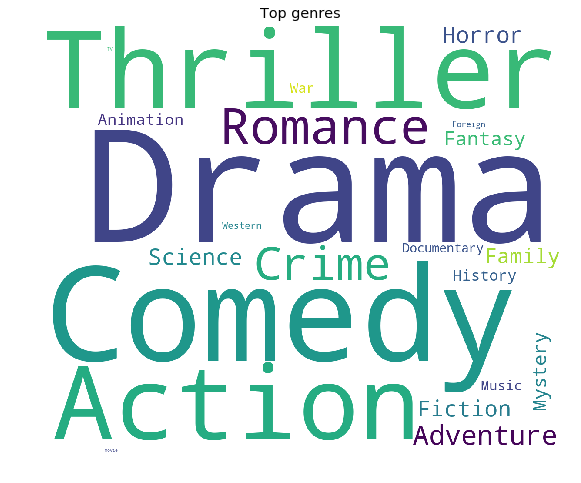

In [25]:
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_genres for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                       width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis("off")
plt.show()

In [16]:
Counter([i for j in list_of_genres for i in j]).most_common(10)

[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260)]

Drama, comedy and thrillers are popular genres in terms of number of films made in the genre.


#### Create additional column for number of genres a film belongs to and list of those genres

In [14]:
train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)
#train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
train['list_genres'] = train['genres'].apply(lambda x: list(sorted([i['name'] for i in x])) if x != {} else '')
    
test['num_genres'] = test['genres'].apply(lambda x: len(x) if x != {} else 0)
#test['all_genres'] = test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
test['list_genres'] = test['genres'].apply(lambda x: list(sorted([i['name'] for i in x])) if x != {} else '')

train = train.drop(['genres'], axis=1)
test = test.drop(['genres'], axis=1)


Text(0,0.5,'Average Revenue')

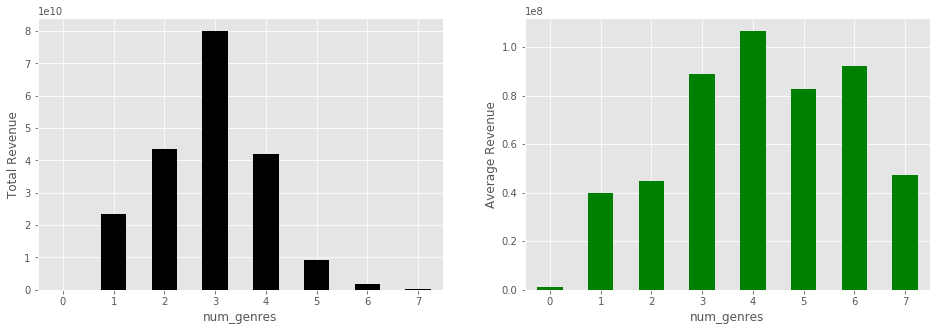

In [27]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
train.groupby(train['num_genres'])['revenue'].sum().plot(kind = 'bar', color = 'black',rot = 0)
plt.ylabel('Total Revenue')
plt.subplot(1, 2, 2)
train.groupby(train['num_genres'])['revenue'].mean().plot(kind = 'bar', color = 'green', rot = 0)
plt.ylabel('Average Revenue')

It appears that the total revenue is higher for films that feature in multiple genres (2 to 4). Let us now try to get the genres that lead to the highest total revenues

In [28]:
temp_df = train[['id', 'revenue', 'list_genres']]
temp_df = temp_df.list_genres.apply(pd.Series) \
            .merge(temp_df, right_index = True, left_index = True) \
            .drop(["list_genres"], axis = 1) \
            .melt(id_vars = ['id', 'revenue'], value_name = "genre") \
            .drop("variable", axis = 1) \
            .dropna()
temp_df_sorted_total  = temp_df.groupby(temp_df['genre'])['revenue'].sum().sort_values(ascending = False)
temp_df_sorted_avg  = temp_df.groupby(temp_df['genre'])['revenue'].mean().sort_values(ascending = False)


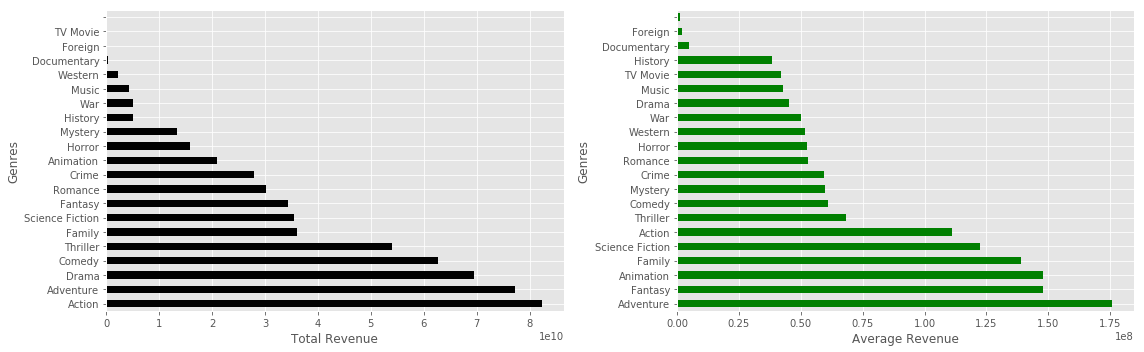

In [29]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
temp_df_sorted_total.plot(kind = 'barh', color = 'black')
plt.xlabel('Total Revenue')
# plt.xticks(rotation = 'vertical')
plt.ylabel('Genres')
plt.subplot(1, 2, 2)
temp_df_sorted_avg.plot(kind = 'barh', color = 'green')
plt.xlabel('Average Revenue')
# plt.xticks(rotation = 'vertical')
plt.ylabel('Genres')
plt.tight_layout()

We will now create separate columns for the top 10 revenue(total) contributing genres seen above - Action, Adventure, Drama, Comedy, Thriller, Family, Science Fiction, Fantasy, Romance, Crime.



In [15]:
top_genres = ['Action', 'Adventure', 'Drama', 'Comedy', 'Thriller', 'Family', 'Science Fiction', 'Fantasy', 'Romance', 'Crime']
for g in top_genres:
    train['genre_' + g] = train['list_genres'].apply(lambda x: 1 if g in x else 0)
    test['genre_' + g] = test['list_genres'].apply(lambda x: 1 if g in x else 0)
    
train = train.drop('list_genres', axis = 1)
test = test.drop('list_genres', axis = 1)

#### Production Companies

In [36]:
for i, e in enumerate(train['production_companies'][:5]):
    print(i, e)

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 {}
4 {}


In [37]:
print('Number of production companies in films')
train['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of production companies in films


1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
11      7
10      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: production_companies, dtype: int64

Most films have one or two production companies but 5 ,6 or even 7 production companies for a film is not uncommon!

In [19]:
list_of_companies = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [20]:
Counter([i for j in list_of_companies for i in j]).most_common(10)

[('Warner Bros.', 202),
 ('Universal Pictures', 188),
 ('Paramount Pictures', 161),
 ('Twentieth Century Fox Film Corporation', 138),
 ('Columbia Pictures', 91),
 ('Metro-Goldwyn-Mayer (MGM)', 84),
 ('New Line Cinema', 75),
 ('Touchstone Pictures', 63),
 ('Walt Disney Pictures', 62),
 ('Columbia Pictures Corporation', 61)]

Warners Bros, Universal Pictures, Paramount Pictures are the top production companies in terms of number of films 

#### Create additional column for number of production companies a film has and list of names of those companies

In [16]:
train['num_companies'] = train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train['list_production_companies'] = train['production_companies'].apply(lambda x: list(sorted([i['name'] for i in x])) if x != {} else [])

test['num_companies'] = test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test['list_production_companies'] = test['production_companies'].apply(lambda x: list(sorted([i['name'] for i in x])) if x != {} else [])


train = train.drop(['production_companies'], axis=1)
test = test.drop(['production_companies'], axis=1)

Text(0,0.5,'Average Revenue')

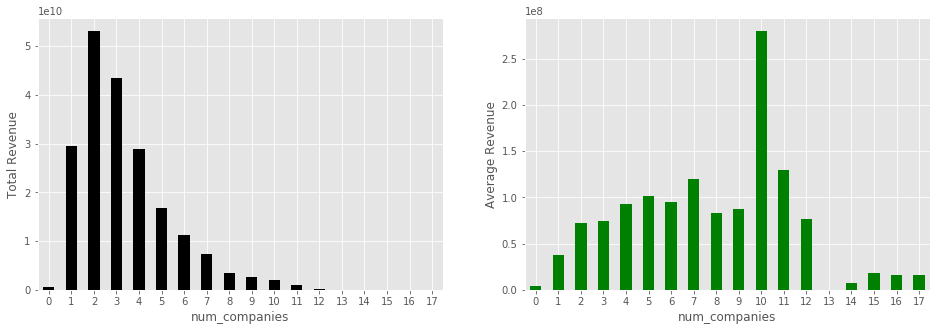

In [32]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
train.groupby('num_companies').agg('sum')['revenue'].plot(kind='bar', color = 'black',rot=0)
plt.ylabel('Total Revenue')
plt.subplot(1, 2, 2)
train.groupby('num_companies').agg('mean')['revenue'].plot(kind='bar', color = 'green',rot=0)
plt.ylabel('Average Revenue')


It seems that the a higher total revenue is associated with films with 2 or 3 production companies though average revenues are in general similar across categories.. The very high average reveneue associated with films with 10 production companies could indicate an outlier.

In [33]:
temp_df = train[['id', 'revenue', 'list_production_companies']]
temp_df = temp_df.list_production_companies.apply(pd.Series) \
            .merge(temp_df, right_index = True, left_index = True) \
            .drop(["list_production_companies"], axis = 1) \
            .melt(id_vars = ['id', 'revenue'], value_name = "production_companies") \
            .drop("variable", axis = 1) \
            .dropna()
temp_df_sorted_total  = temp_df.groupby(temp_df['production_companies'])['revenue'].sum().sort_values(ascending = False)
temp_df_sorted_avg  = temp_df.groupby(temp_df['production_companies'])['revenue'].mean().sort_values(ascending = False)
#print(temp_df_sorted[:20])


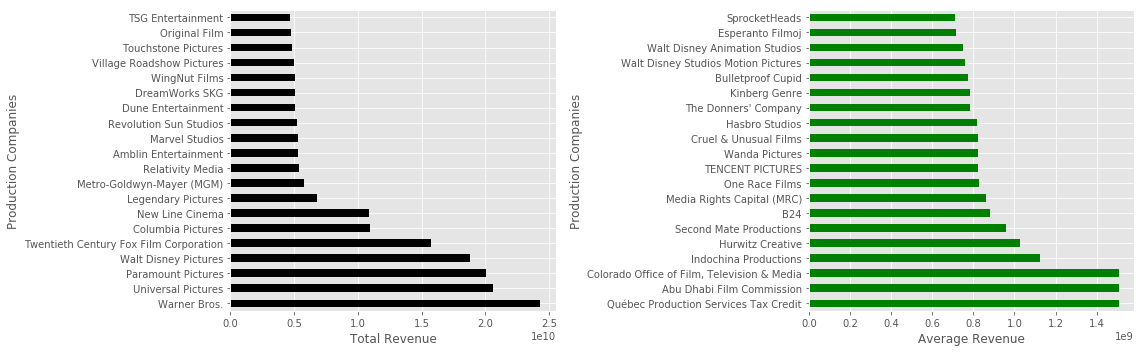

In [34]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
temp_df_sorted_total[:20].plot(kind = 'barh', color = 'black')
plt.xlabel('Total Revenue')
# # plt.xticks(rotation = 'vertical')
plt.ylabel('Production Companies')
plt.subplot(1, 2, 2)
temp_df_sorted_avg[:20].plot(kind = 'barh', color = 'green')
plt.xlabel('Average Revenue')
plt.ylabel('Production Companies')
plt.tight_layout()

We will now create separate columns for the top 10 revenue(total) contributing companies.

In [17]:
top_companies = ['Warner Bros.', 'Universal Pictures', 'Paramount Pictures', 'Walt Disney Pictures', 'Twentieth Century Fox Film Corporation', 'Columbia Pictures', 'New Line Cinema', 'Legendary Pictures', 'Metro-Goldwyn-Mayer (MGM)', 'Relativity Media']
for g in top_companies:
    train['production_companies_' + g] = train['list_production_companies'].apply(lambda x: 1 if g in x else 0)
    test['production_companies_' + g] = test['list_production_companies'].apply(lambda x: 1 if g in x else 0)
    
train = train.drop('list_production_companies', axis = 1)
test = test.drop('list_production_companies', axis = 1)


#### Production Countries

In [44]:
for i, e in enumerate(train['production_countries'][:5]):
    print(i, e)

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]


In [48]:
print('Number of production countries in films')
train['production_countries'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of production countries in films


1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64

Normally films are produced by a single country but there are cases of multiple countries collaborating

In [23]:
list_of_countries = list(train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_countries for i in j]).most_common(10)

[('United States of America', 2282),
 ('United Kingdom', 380),
 ('France', 222),
 ('Germany', 167),
 ('Canada', 120),
 ('India', 81),
 ('Italy', 64),
 ('Japan', 61),
 ('Australia', 61),
 ('Russia', 58)]

#### Create additional columns for number of production countries a film has and names of those countries

In [18]:
train['num_countries'] = train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train['list_production_countries'] = train['production_countries'].apply(lambda x: list(sorted([i['name'] for i in x])) if x != {} else [])

    
test['num_countries'] = test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test['list_production_countries'] = test['production_countries'].apply(lambda x: list(sorted([i['name'] for i in x])) if x != {} else [])

train = train.drop(['production_countries'], axis=1)
test = test.drop(['production_countries'], axis=1)

Text(0,0.5,'Average Revenue')

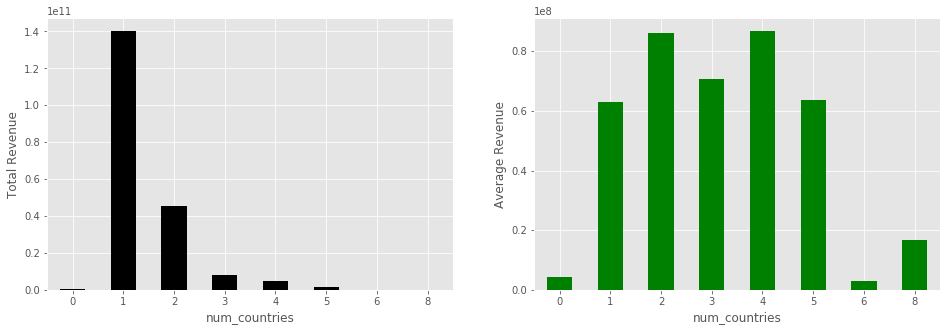

In [37]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
train.groupby('num_countries').agg('sum')['revenue'].plot(kind='bar', color = 'black',rot=0)
plt.ylabel('Total Revenue')
plt.subplot(1, 2, 2)
train.groupby('num_countries').agg('mean')['revenue'].plot(kind='bar', color = 'green',rot=0)
plt.ylabel('Average Revenue')

It seems that the highest total revenues come from single-country productions. Let us now try to identify the countries with the highest film revenues.

In [38]:
temp_df = train[['id', 'revenue', 'list_production_countries']]
temp_df = temp_df.list_production_countries.apply(pd.Series) \
            .merge(temp_df, right_index = True, left_index = True) \
            .drop(["list_production_countries"], axis = 1) \
            .melt(id_vars = ['id', 'revenue'], value_name = "production_countries") \
            .drop("variable", axis = 1) \
            .dropna()
temp_df_sorted_total  = temp_df.groupby(temp_df['production_countries'])['revenue'].sum().sort_values(ascending = False)
temp_df_sorted_avg  = temp_df.groupby(temp_df['production_countries'])['revenue'].mean().sort_values(ascending = False)
#temp_df_sorted[:10]


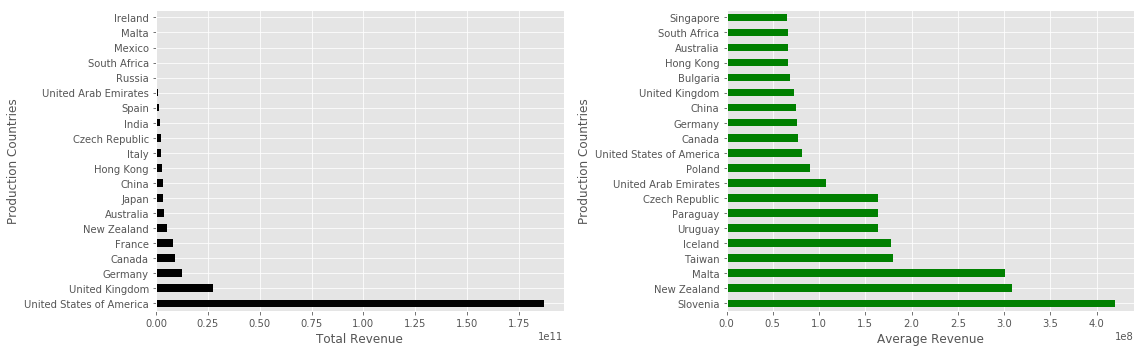

In [39]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
temp_df_sorted_total[:20].plot(kind = 'barh', color = 'black')
plt.xlabel('Total Revenue')
# # plt.xticks(rotation = 'vertical')
plt.ylabel('Production Countries')
plt.subplot(1, 2, 2)
temp_df_sorted_avg[:20].plot(kind = 'barh', color = 'green')
plt.xlabel('Average Revenue')
# # plt.xticks(rotation = 'vertical')
plt.ylabel('Production Countries')
plt.tight_layout()

It is clear that films produced in the United States earn a bigger share of total revenue compared to films from other countries. The average revenue figures are not very informative as the top 10 countries are those with insignifcant share of total revenue. We will therefore create one additional variable indicating whether the production country is USA or not.

In [19]:
train['production_country_is_USA'] = train['list_production_countries'].apply(lambda x: 1 if 'United States of America' in x else 0)
test['production_country_is_USA'] = test['list_production_countries'].apply(lambda x: 1 if 'United States of America' in x else 0)

train = train.drop('list_production_countries', axis = 1)
test = test.drop('list_production_countries', axis = 1)

#### Spoken Languages

In [55]:
for i, e in enumerate(train['spoken_languages'][:5]):
    print(i, e)

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [56]:
print('Number of spoken languages in films')
train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()


Number of spoken languages in films


1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

In [26]:
list_of_languages = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_languages for i in j]).most_common(15)

[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27)]

The most common spoken language in films is English. Though it is most common to see only one spoken language in a film there are films with multiple spoken languages.

#### Create additional columns for number of spoken languages a film has and names of those languages

In [20]:
train['num_languages'] = train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train['list_languages'] = train['spoken_languages'].apply(lambda x: list(sorted([i['name'] for i in x])) if x != {} else [])

test['num_languages'] = test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
test['list_languages'] = test['spoken_languages'].apply(lambda x: list(sorted([i['name'] for i in x])) if x != {} else [])

train = train.drop(['spoken_languages'], axis=1)
test = test.drop(['spoken_languages'], axis=1)


Text(0,0.5,'Average Revenue')

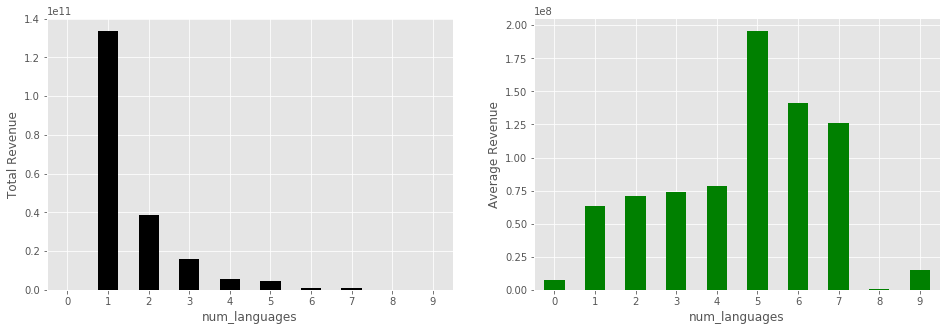

In [42]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
train.groupby('num_languages').agg('sum')['revenue'].plot(kind='bar', color = 'black',rot=0)
plt.ylabel('Total Revenue')
plt.subplot(1, 2, 2)
train.groupby('num_languages').agg('mean')['revenue'].plot(kind='bar', color = 'green',rot=0)
plt.ylabel('Average Revenue')


It is clear that the largest share of total revenue comes from single-language films rather than multi-language films. Let us now identify that languages that see the highest revenues.

In [43]:
temp_df = train[['id', 'revenue', 'list_languages']]
temp_df = temp_df.list_languages.apply(pd.Series) \
            .merge(temp_df, right_index = True, left_index = True) \
            .drop(["list_languages"], axis = 1) \
            .melt(id_vars = ['id', 'revenue'], value_name = "spoken_languages") \
            .drop("variable", axis = 1) \
            .dropna()
temp_df_sorted_total  = temp_df.groupby(temp_df['spoken_languages'])['revenue'].sum().sort_values(ascending = False)
temp_df_sorted_avg  = temp_df.groupby(temp_df['spoken_languages'])['revenue'].mean().sort_values(ascending = False)
#temp_df_sorted[:10]

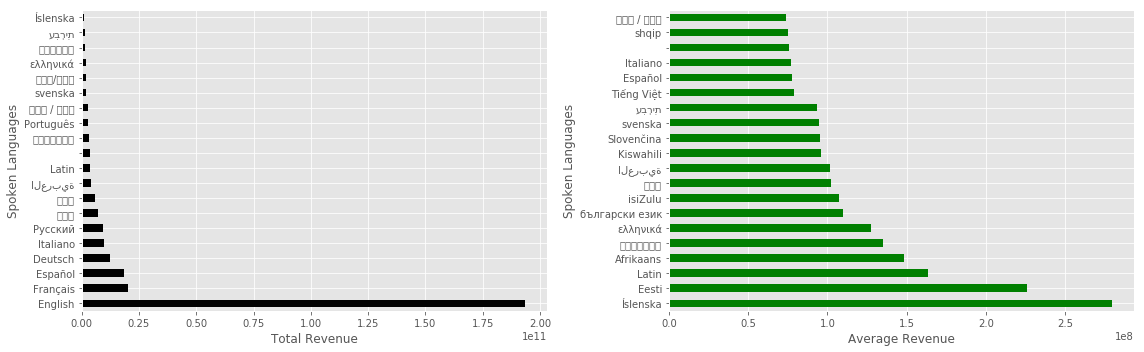

In [45]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
temp_df_sorted_total[:20].plot(kind = 'barh', color = 'black')
plt.xlabel('Total Revenue')
# # plt.xticks(rotation = 'vertical')
plt.ylabel('Spoken Languages')
plt.subplot(1, 2, 2)
temp_df_sorted_avg[:20].plot(kind = 'barh', color = 'green')
plt.xlabel('Average Revenue')
# # plt.xticks(rotation = 'vertical')
plt.ylabel('Spoken Languages')
plt.tight_layout()

It is clear that films with English as spoken language earn disproportionately higher revenue compared to films in other languages. The average revenue graph is once again not very informative. We will therefore create one additional variable indicating whether the spoke language is English or not.

In [21]:
train['spoken_language_is_English'] = train['list_languages'].apply(lambda x: 1 if 'English' in x else 0)
test['spoken_language_is_English'] = test['list_languages'].apply(lambda x: 1 if 'English' in x else 0)

train = train.drop('list_languages', axis = 1)
test = test.drop('list_languages', axis = 1)


**Keywords**

In [62]:
for i, e in enumerate(train['Keywords'][:5]):
    print(i, e)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [63]:
print('Number of Keywords in films')
train['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of Keywords in films


5    293
0    276
4    248
3    228
6    227
2    207
7    192
1    187
8    161
9    134
Name: Keywords, dtype: int64

Let us take a look at the most common keywords

In [22]:
list_of_keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

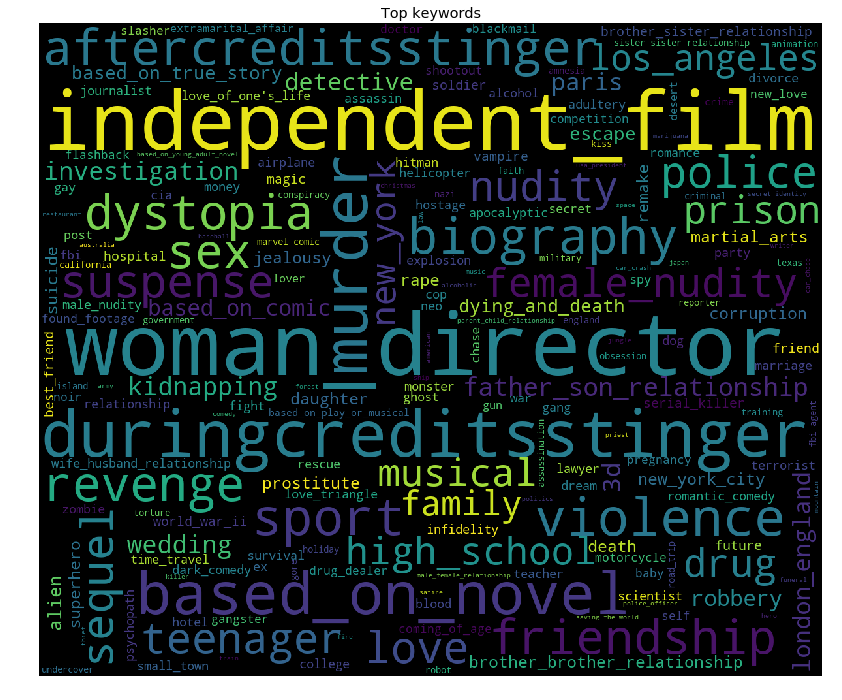

In [23]:

plt.figure(figsize = (16, 12))
text = ' '.join(['_'.join(i.split(' ')) for j in list_of_keywords for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                        width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top keywords')
plt.axis("off")
plt.show()


In [25]:
Counter([i for j in list_of_keywords for i in j]).most_common(20)

[('woman director', 175),
 ('independent film', 155),
 ('duringcreditsstinger', 134),
 ('murder', 123),
 ('based on novel', 111),
 ('violence', 87),
 ('sport', 82),
 ('biography', 77),
 ('aftercreditsstinger', 75),
 ('dystopia', 73),
 ('revenge', 73),
 ('friendship', 72),
 ('sex', 71),
 ('suspense', 67),
 ('sequel', 66),
 ('love', 64),
 ('police', 64),
 ('teenager', 61),
 ('nudity', 57),
 ('female nudity', 53)]

#### Create additional columns for number of keywords a film and whether a film has one of the top 10 most common keywords or not.

In [23]:
train['num_Keywords'] = train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train['all_Keywords'] = train['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(10)]
for g in top_keywords:
    train['keyword_' + g] = train['all_Keywords'].apply(lambda x: 1 if g in x else 0)
    
test['num_Keywords'] = test['Keywords'].apply(lambda x: len(x) if x != {} else 0)
test['all_Keywords'] = test['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_keywords:
    test['keyword_' + g] = test['all_Keywords'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['Keywords', 'all_Keywords'], axis=1)
test = test.drop(['Keywords', 'all_Keywords'], axis=1)


Text(0,0.5,'Average Revenue')

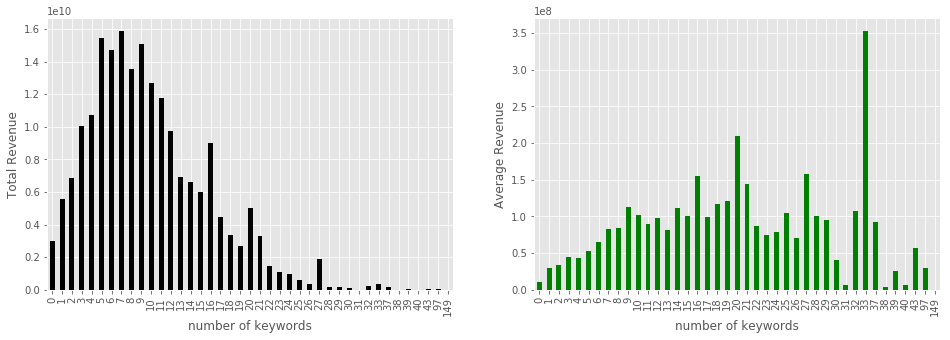

In [49]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
train.groupby('num_Keywords').agg('sum')['revenue'].plot(kind='bar', color = 'black',rot=0)
plt.xlabel('number of keywords')
plt.xticks(rotation = 'vertical')
plt.ylabel('Total Revenue')
plt.subplot(1, 2, 2)
train.groupby('num_Keywords').agg('mean')['revenue'].plot(kind='bar', color = 'green',rot=0)
plt.xlabel('number of keywords')
plt.xticks(rotation = 'vertical')
plt.ylabel('Average Revenue')


It appears that films with about 7 - 10 keywords in a film are associated with higher revenues. 

#### Cast

In [ ]:
for i, e in enumerate(train['cast'][:2]):
    print(i, e)

In [63]:
print('Number of casted persons in films')
train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of casted persons in films


15    212
16    165
10    135
13    129
12    124
11    122
9     118
17    118
18    115
14    110
Name: cast, dtype: int64

Those who are casted heavily impact the fortunes of a film. Let us take a look at the popular names

In [32]:
list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(15)


[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21)]

**Create additional columns for number of cast members and list of cast members**

In [24]:
train['num_cast'] = train['cast'].apply(lambda x: len(x) if x != {} else 0)
train['list_cast'] = train['cast'].apply(lambda x: list(sorted([i['name'] for i in x])) if x != {} else [])

test['num_cast'] = test['cast'].apply(lambda x: len(x) if x != {} else 0)
test['list_cast'] = test['cast'].apply(lambda x: list(sorted([i['name'] for i in x])) if x != {} else [])


Text(0,0.5,'Average Revenue')

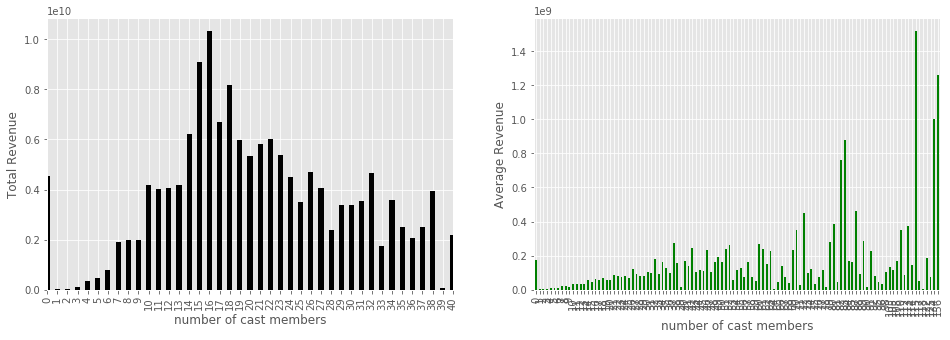

In [57]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
train.groupby('num_cast').agg('sum')['revenue'].plot(kind='bar', color = 'black',rot=0)
plt.xlabel('number of cast members')
plt.xlim(0,40)
plt.xticks(rotation = 'vertical')
plt.ylabel('Total Revenue')
plt.subplot(1, 2, 2)
train.groupby('num_cast').agg('mean')['revenue'].plot(kind='bar', color = 'green',rot=0)
plt.xlabel('number of cast members')
#plt.xlim(0,30)
plt.xticks(rotation = 'vertical')
plt.ylabel('Average Revenue')

It appears that total revenue is highest for films with 15 -16 cast members.

Let us try to identify the actors associated with the highest film revenues.

In [58]:
temp_df = train[['id', 'revenue', 'list_cast']]
temp_df = temp_df.list_cast.apply(pd.Series) \
            .merge(temp_df, right_index = True, left_index = True) \
            .drop(["list_cast"], axis = 1) \
            .melt(id_vars = ['id', 'revenue'], value_name = "cast_member") \
            .drop("variable", axis = 1) \
            .dropna()
temp_df_sorted_total  = temp_df.groupby(temp_df['cast_member'])['revenue'].sum().sort_values(ascending = False)
temp_df_sorted_avg  = temp_df.groupby(temp_df['cast_member'])['revenue'].mean().sort_values(ascending = False)
#temp_df_sorted[:10]

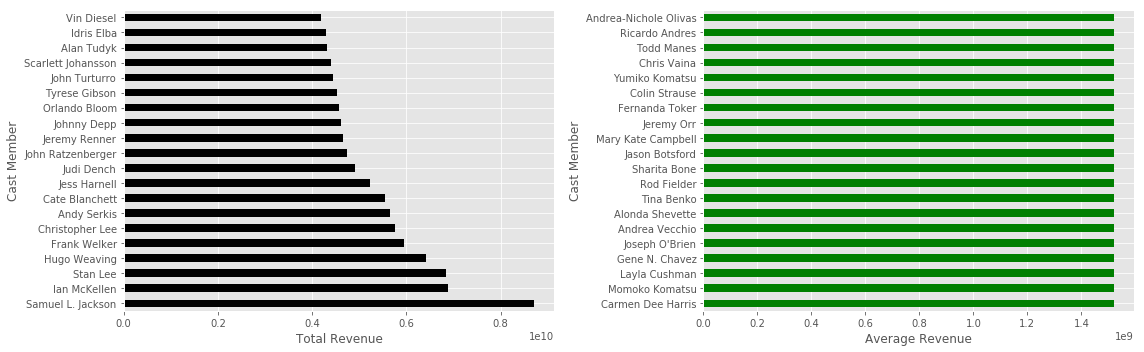

In [59]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
temp_df_sorted_total[:20].plot(kind = 'barh', color = 'black')
plt.xlabel('Total Revenue')
# # plt.xticks(rotation = 'vertical')
plt.ylabel('Cast Member')
plt.subplot(1, 2, 2)
temp_df_sorted_avg[:20].plot(kind = 'barh', color = 'green')
plt.xlabel('Average Revenue')
# # plt.xticks(rotation = 'vertical')
plt.ylabel('Cast Member')
plt.tight_layout()

We will now create additional columns for the top 10 revenue(total) contributing actors.

In [25]:
top_cast = ['Samuel L. Jackson', 'Ian McKellen', 'Stan Lee', 'Hugo Weaving', 'Frank Welker', 'Christopher Lee', 'Andy Serkis', 'Cate Blanchett', 'Jess Harnell', 'Judi Dench']
for g in top_cast:
    train['cast_member_' + g] = train['list_cast'].apply(lambda x: 1 if g in x else 0)
    test['cast_member_' + g] = test['list_cast'].apply(lambda x: 1 if g in x else 0)
    
train = train.drop('list_cast', axis = 1)
test = test.drop('list_cast', axis = 1)


The number of people from different genders in a film can also have an impact on a film's revenue - whether it is more male or women-centric. Hence we create separate variables to capture this effect, if any. As per the competition guidelines 1 is female, 2 is male and 0 unspecified.

In [26]:
list_of_cast_genders = list(train['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)

train['cast_genders_0'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['cast_genders_1'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['cast_genders_2'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

test['cast_genders_0'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['cast_genders_1'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['cast_genders_2'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

train = train.drop(['cast'], axis=1)
test = test.drop(['cast'], axis=1)


**Crew**

In [75]:
for i, e in enumerate(train['crew'][:1]):
    print(i, e[:10])
    

0 [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id': 14

In [76]:
print('Number of crew members in films')
train['crew'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of crew members in films


2     179
11    127
10    126
3     126
12    110
9     109
8     109
14    104
4     101
7      94
Name: crew, dtype: int64

Just like a great cast, a stellar crew is important for the fortunes of a film. Let us first have a look at the popular names.

In [62]:
list_of_crew_names = list(train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

Let us also take a look at the most common crew departments and jobs

In [27]:
list_of_crew_departments = list(train['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_departments for i in j]).most_common(15)


[('Production', 15887),
 ('Sound', 9319),
 ('Art', 8069),
 ('Crew', 7315),
 ('Writing', 6567),
 ('Costume & Make-Up', 6156),
 ('Camera', 5424),
 ('Directing', 4954),
 ('Editing', 4508),
 ('Visual Effects', 3591),
 ('Lighting', 1303),
 ('Actors', 4)]

In [28]:
list_of_crew_jobs = list(train['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)


[('Producer', 6011),
 ('Executive Producer', 3459),
 ('Director', 3225),
 ('Screenplay', 2996),
 ('Editor', 2824),
 ('Casting', 2483),
 ('Director of Photography', 2288),
 ('Original Music Composer', 1947),
 ('Art Direction', 1821),
 ('Production Design', 1650),
 ('Costume Design', 1573),
 ('Writer', 1523),
 ('Set Decoration', 1345),
 ('Makeup Artist', 1108),
 ('Sound Re-Recording Mixer', 970)]

#### Create additional columns for number of crew members and list of crew members.

In [29]:
train['num_crew'] = train['crew'].apply(lambda x: len(x) if x != {} else 0)
train['list_crew'] = train['crew'].apply(lambda x: list(sorted([i['name'] for i in x])) if x != {} else [])

test['num_crew'] = test['crew'].apply(lambda x: len(x) if x != {} else 0)
test['list_crew'] = test['crew'].apply(lambda x: list(sorted([i['name'] for i in x])) if x != {} else [])


Text(0,0.5,'Average Revenue')

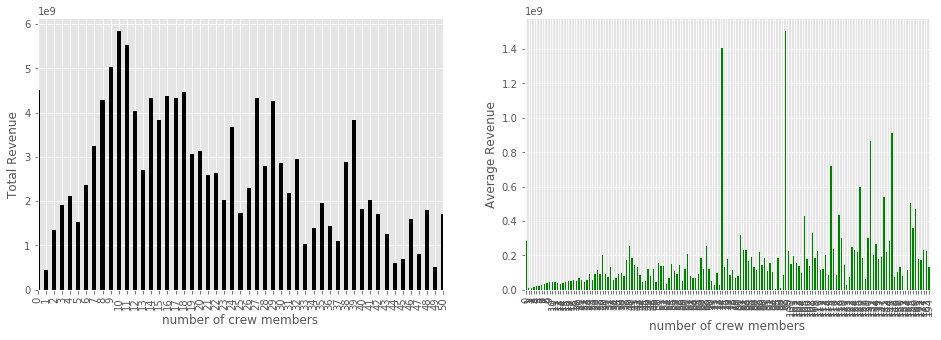

In [66]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
train.groupby('num_crew').agg('sum')['revenue'].plot(kind='bar', color = 'black',rot=0)
plt.xlabel('number of crew members')
plt.xlim(0,50)
plt.xticks(rotation = 'vertical')
plt.ylabel('Total Revenue')
plt.subplot(1, 2, 2)
train.groupby('num_crew').agg('mean')['revenue'].plot(kind='bar', color = 'green',rot=0)
plt.xlabel('number of crew members')
plt.xticks(rotation = 'vertical')
plt.ylabel('Average Revenue')

While there seems to be outliers in both graphs, the highest revenues are associated with films with around 10 or 11 crew members. Let us try to identify the crew members with the highest revenues.

In [67]:
temp_df = train[['id', 'revenue', 'list_crew']]
temp_df = temp_df.list_crew.apply(pd.Series) \
            .merge(temp_df, right_index = True, left_index = True) \
            .drop(["list_crew"], axis = 1) \
            .melt(id_vars = ['id', 'revenue'], value_name = "crew_member") \
            .drop("variable", axis = 1) \
            .dropna()
temp_df_sorted_total  = temp_df.groupby(temp_df['crew_member'])['revenue'].sum().sort_values(ascending = False)
temp_df_sorted_avg  = temp_df.groupby(temp_df['crew_member'])['revenue'].mean().sort_values(ascending = False)
#temp_df_sorted[:10]

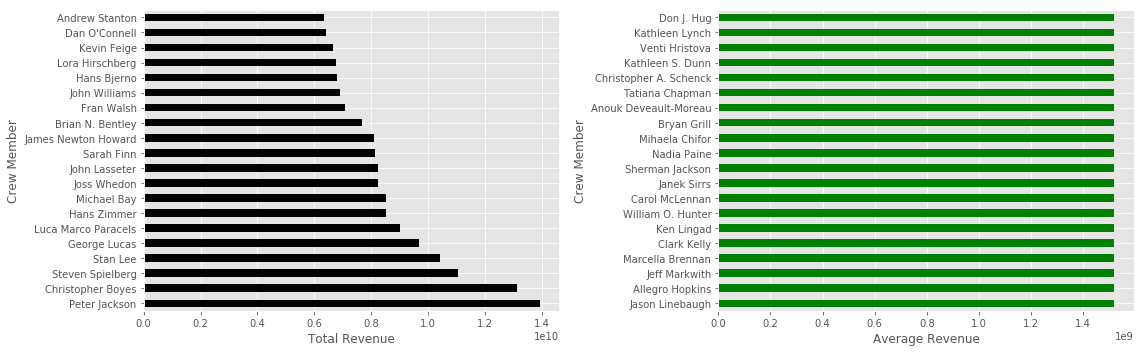

In [68]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
temp_df_sorted_total[:20].plot(kind = 'barh', color = 'black')
plt.xlabel('Total Revenue')
# # plt.xticks(rotation = 'vertical')
plt.ylabel('Crew Member')
plt.subplot(1, 2, 2)
temp_df_sorted_avg[:20].plot(kind = 'barh', color = 'green')
plt.xlabel('Average Revenue')
# # plt.xticks(rotation = 'vertical')
plt.ylabel('Crew Member')
plt.tight_layout()

We will now create additional columns for the top 10 revenue(total) contributing crew.

In [30]:
top_crew = ['Peter Jackson', 'Christopher Boyes', 'Steven Spielberg', 'Stan Lee', 'George Lucas', 'Luca Marco Paracels', 'Hans Zimmer', 'Michael Bay', 'Joss Whedon', 'John Lasseter']
for g in top_crew:
    train['crew_member_' + g] = train['list_crew'].apply(lambda x: 1 if g in x else 0)
    test['crew_member_' + g] = test['list_crew'].apply(lambda x: 1 if g in x else 0)
    
train = train.drop('list_crew', axis = 1)
test = test.drop('list_crew', axis = 1)

We will also create additional columns for whether the top 10 crew departments and top 10 crew jobs are present in a film.


In [31]:
top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(10)]
for j in top_crew_jobs:
    train['jobs_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
    test['jobs_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))

top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(10)]
for j in top_crew_departments:
    train['departments_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 
    test['departments_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 
    
train = train.drop('crew', axis = 1)
test = test.drop('crew', axis = 1)

#### Data exploration of other variables - homepage, original language, original title, overview, tagline, status, title.

**Homepage**

In [32]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1
train = train.drop('homepage', axis = 1)
test = test.drop('homepage', axis = 1)

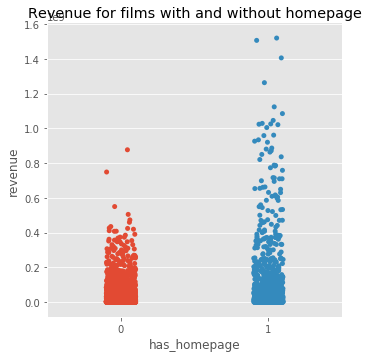

In [36]:
sns.catplot(x='has_homepage', y='revenue', data=train);
plt.title('Revenue for films with and without homepage');

Films with homepage tend to generate more revenue.

**Original Language**

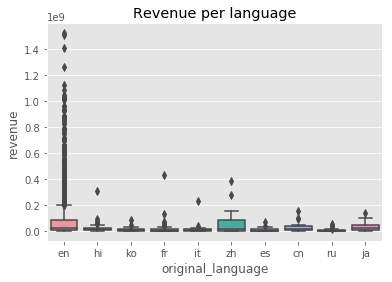

In [45]:

sns.boxplot(x='original_language', y='revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Revenue per language');


As seen with 'Spoken Language' before, the highest revenue is associated with films orginally in English. We will create one additional variable to indicate if original spoken language is English or not.

In [33]:
train['isOriginalLanguageEng'] = 0 
train.loc[ train['original_language'] == "en" ,"isOriginalLanguageEng"] = 1

test['isOriginalLanguageEng'] = 0 
test.loc[ test['original_language'] == "en" ,"isOriginalLanguageEng"] = 1

train = train.drop('original_language', axis = 1)
test = test.drop('original_language', axis = 1)


**Original title**

It may be interesting to see which words come up most frequently in original titles.

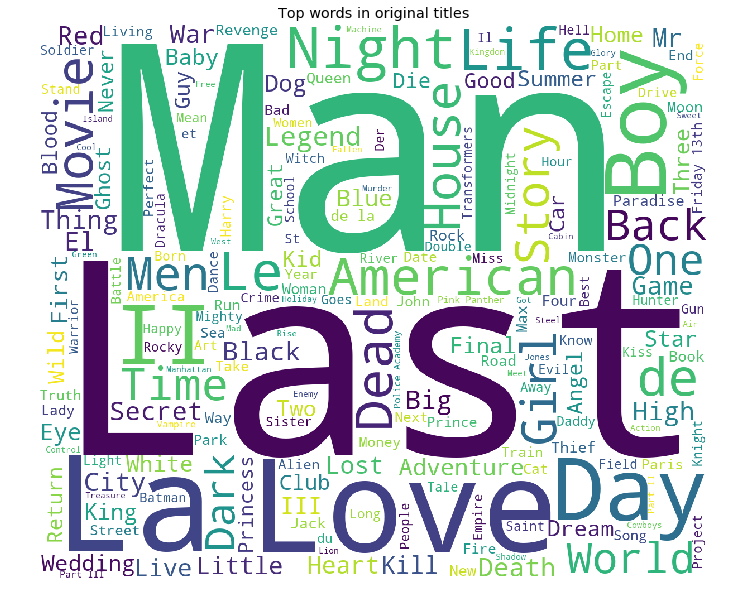

In [94]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['original_title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in original titles')
plt.axis("off")
plt.show()

We will create one additional column for number of words in original title. The length of a title can have a bearing on a movie's popularity at the box office.

In [34]:
train['original_title_word_count'] = train['original_title'].str.split().str.len() 
test['original_title_word_count'] = test['original_title'].str.split().str.len() 


**Overview - common words that feature**

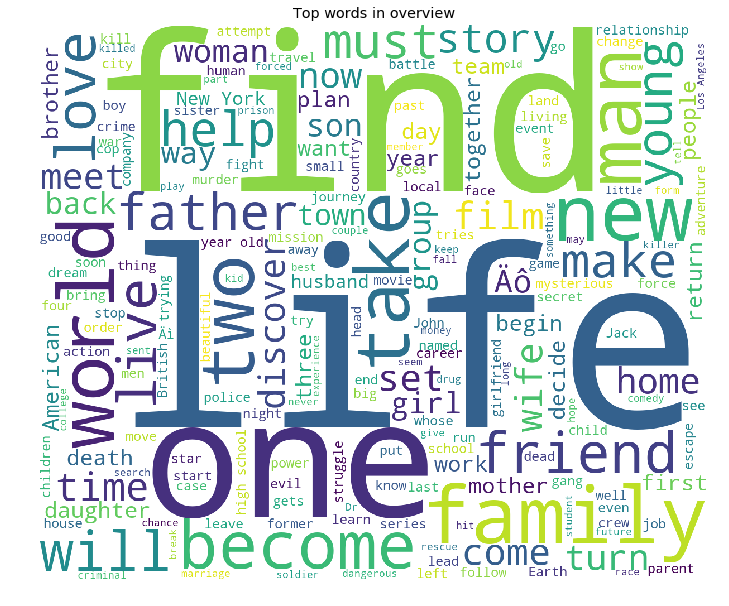

In [91]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in overview')
plt.axis("off")
plt.show()

We will create one additional variable to indicate overview word count.

In [35]:
train['overview_word_count'] = train['overview'].str.split().str.len()
test['overview_word_count'] = test['overview'].str.split().str.len()

train = train.drop('overview', axis = 1)
test = test.drop('overview', axis = 1)


**Tagline - common words**

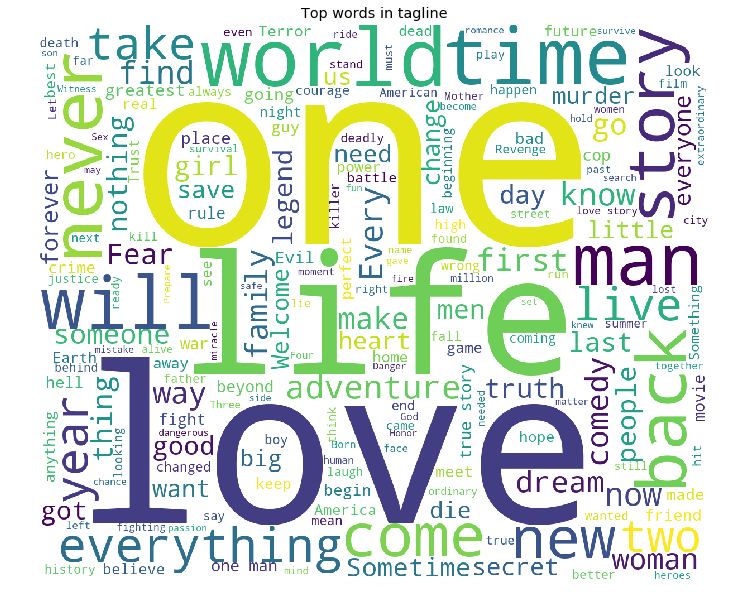

In [92]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['tagline'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in tagline')
plt.axis("off")
plt.show()

We will create one additional variable to indicate if the movie has a tagline or not and another to indicate tagline word count.

In [36]:
train['has_tagline'] = 0
train.loc[train['tagline'].isnull() == False, 'has_tagline'] = 1
test['has_tagline'] = 0
test.loc[test['tagline'].isnull() == False, 'has_tagline'] = 1

train['tagline_word_count'] = train['tagline'].str.split().str.len()
test['tagline_word_count'] = test['tagline'].str.split().str.len()

train = train.drop('tagline', axis = 1)
test = test.drop('tagline', axis = 1)

**Status**

In [41]:
print(train['status'].value_counts())
print(test['status'].value_counts())

Released    2996
Rumored        4
Name: status, dtype: int64
Released           4389
Post Production       5
Rumored               2
Name: status, dtype: int64


As we can see only 4 films in train data and 7 films in test data are not released yet. Hence this feature may not be informative.

**Title - common words**

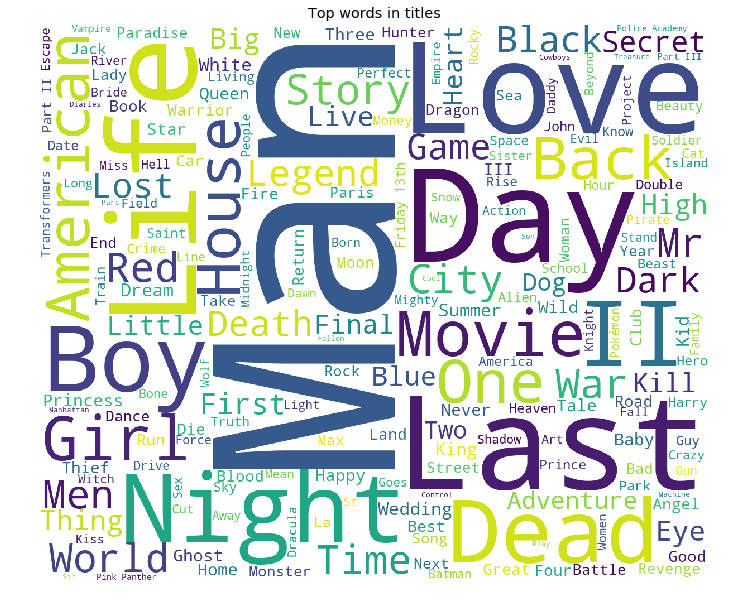

In [95]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

We will create one additional variable for title word count and another to indicate if title is different from original title

In [37]:
train['isTitleDifferent'] = 1
train.loc[ train['original_title'] == train['title'] ,"isTitleDifferent"] = 0 

test['isTitleDifferent'] = 1
test.loc[ test['original_title'] == test['title'] ,"isTitleDifferent"] = 0 

train = train.drop('original_title', axis = 1)
test = test.drop('original_title', axis = 1)

In [38]:
train['title_word_count'] = train['title'].str.split().str.len()
test['title_word_count'] = test['title'].str.split().str.len()

train = train.drop('title', axis = 1)
test = test.drop('title', axis = 1)

**Drop id and other variables that may not be indicative**

In [44]:
train_id = train['id']
test_id = test['id']
drop_columns=['id','imdb_id','poster_path','status']
train_new=train.drop(drop_columns,axis=1)
test_new=test.drop(drop_columns,axis=1)

In [45]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 101 entries, budget to log_revenue
dtypes: float64(6), int64(95)
memory usage: 2.3 MB


In [42]:
test_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 99 columns):
budget                                                         4398 non-null float64
popularity                                                     4398 non-null float64
runtime                                                        4398 non-null float64
release_year                                                   4398 non-null int64
release_month                                                  4398 non-null int64
release_day                                                    4398 non-null int64
release_weekday                                                4398 non-null int64
release_quarter                                                4398 non-null int64
has_collection                                                 4398 non-null int64
num_genres                                                     4398 non-null int64
genre_Action                                             

In [42]:
train_new.isna().sum().sort_values(ascending = False)[:20]

tagline_word_count                                             597
overview_word_count                                              8
title_word_count                                                 0
spoken_language_is_English                                       0
production_companies_Walt Disney Pictures                        0
production_companies_Twentieth Century Fox Film Corporation      0
production_companies_Columbia Pictures                           0
production_companies_New Line Cinema                             0
production_companies_Legendary Pictures                          0
production_companies_Metro-Goldwyn-Mayer (MGM)                   0
production_companies_Relativity Media                            0
num_countries                                                    0
production_country_is_USA                                        0
num_languages                                                    0
num_Keywords                                                  

In [43]:
test_new.isna().sum().sort_values(ascending = False)[:20]

tagline_word_count                                             863
overview_word_count                                             14
title_word_count                                                 3
num_Keywords                                                     0
production_companies_Twentieth Century Fox Film Corporation      0
production_companies_Columbia Pictures                           0
production_companies_New Line Cinema                             0
production_companies_Legendary Pictures                          0
production_companies_Metro-Goldwyn-Mayer (MGM)                   0
production_companies_Relativity Media                            0
num_countries                                                    0
production_country_is_USA                                        0
num_languages                                                    0
spoken_language_is_English                                       0
keyword_woman director                                        

Since there are still some missing values in the datasets we will replace them with 0s.

In [46]:
for col in ('tagline_word_count', 'overview_word_count', 'title_word_count'):
    train_new[col] = train_new[col].fillna(0)
    test_new[col] = test_new[col].fillna(0)


## Modelling

In [47]:
#Formatting for modeling
X = train_new.drop(['revenue', 'log_revenue'], axis=1)
y = train_new['log_revenue']
X_test = test_new
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state = 42)

**Basic Model 1: XGBoost**

In [48]:
xgb_params = {'learning_rate': 0.01,
              'objective': 'reg:linear',
              'max_depth': 5,
              'gamma' : 0,
              'min_child_weight': 3,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}

xgb_model_1 = xgb.XGBRegressor(**xgb_params, n_estimators = 10000, n_jobs = 4)
xgb_model_1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

[0]	validation_0-rmse:15.6443	validation_1-rmse:15.7902
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 200 rounds.
[1000]	validation_0-rmse:1.03113	validation_1-rmse:1.70215
Stopping. Best iteration:
[1090]	validation_0-rmse:0.99357	validation_1-rmse:1.69903



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='rmse', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=3, missing=None, n_estimators=10000, n_jobs=4,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=11, silent=True,
       subsample=0.8)

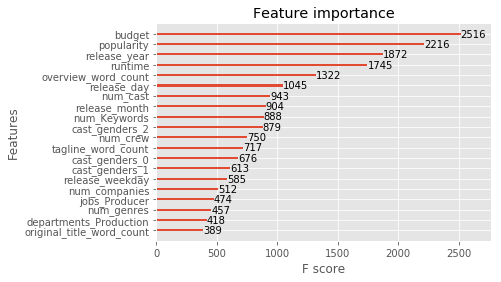

In [48]:
xgb.plot_importance(xgb_model_1, max_num_features = 20)

**Basic Model 2: LightGBM**

In [49]:
lgb_params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         #"feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse'}
         #"lambda_l1": 0.2,
         #"verbosity": -1}

lgb_model_1 = lgb.LGBMRegressor(**lgb_params, n_estimators = 10000, n_jobs = 4)

lgb_model_1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)


Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.17465	valid_1's rmse: 1.73127
Early stopping, best iteration is:
[997]	training's rmse: 1.17555	valid_1's rmse: 1.73125


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
       boosting='gbdt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
       max_depth=5, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
       n_estimators=10000, n_jobs=4, num_leaves=30, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

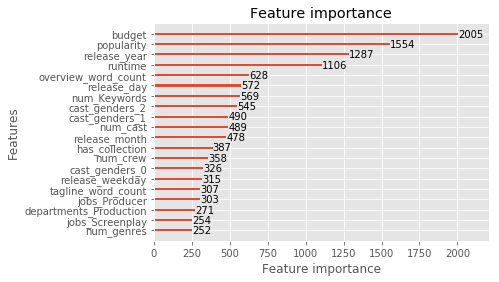

In [98]:
lgb.plot_importance(lgb_model_1, max_num_features = 20)

**Basic Model 3: CatBoost**

In [50]:
cb_params = {'learning_rate': 0.02,
              'depth': 5,
              'l2_leaf_reg': 10,
              'bootstrap_type': 'Bernoulli',
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 50,
              'random_seed': 11,
              'allow_writing_files': False}
cb_model_1 = cb.CatBoostRegressor(iterations=10000, eval_metric='RMSE', **cb_params)

cb_model_1.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_valid, y_valid)], cat_features=[], use_best_model=True, verbose=False)

print("RMSE on training data: "+ cb_model_1.score(X_train, y_train).astype(str))
print("RMSE on validation data: "+ cb_model_1.score(X_valid, y_valid).astype(str))

RMSE on training data: 1.2772365329480522
RMSE on validation data: 1.7056594594072256


In [52]:
feature_score = pd.DataFrame(list(zip(X.dtypes.index,cb_model_1.get_feature_importance(cb.Pool(X, label=y, cat_features=[])))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')[:20]

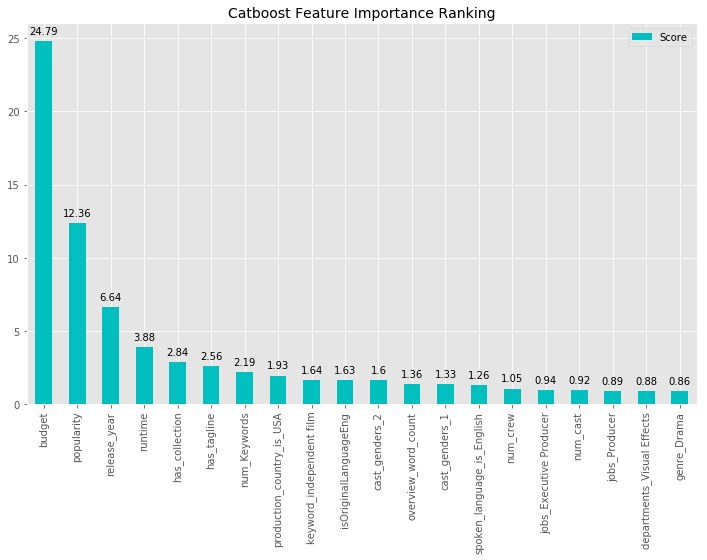

In [53]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

#### K-fold cross-validation and prediction for each basic model

In [51]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)


In [52]:
def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance = True):

    oof = np.zeros(X.shape[0])
    prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        
        X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 10000, nthread = 4, n_jobs = 4)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=10000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)


            
        if model_type == 'cb':
            model = cb.CatBoostRegressor(iterations=10000,  eval_metric='RMSE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)


    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction
    

**XGBoost**

In [53]:
oof_xgb_1, prediction_xgb_1 = train_model(X, X_test, y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Thu Mar 21 08:49:25 2019
[0]	train-rmse:15.6445	valid_data-rmse:15.7905
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.29196	valid_data-rmse:1.73252
[1000]	train-rmse:1.03281	valid_data-rmse:1.70613
Stopping. Best iteration:
[1256]	train-rmse:0.927544	valid_data-rmse:1.70436

Fold 1 started at Thu Mar 21 08:50:12 2019
[0]	train-rmse:15.6877	valid_data-rmse:15.6204
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.32002	valid_data-rmse:1.67497
[1000]	train-rmse:1.05244	valid_data-rmse:1.65011
Stopping. Best iteration:
[1052]	train-rmse:1.02944	valid_data-rmse:1.64859

Fold 2 started at Thu Mar 21 08:50:52 2019
[0]	train-rmse:15.6789	valid_data-rmse:15.6556
Multiple eval metrics have been passed: 'valid_data-rmse' will be

**Light GBM**

Fold 0 started at Thu Mar 21 08:54:11 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.17594	valid_1's rmse: 1.72691
Early stopping, best iteration is:
[1054]	training's rmse: 1.15841	valid_1's rmse: 1.72595
Fold 1 started at Thu Mar 21 08:54:16 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.20036	valid_1's rmse: 1.68549
Early stopping, best iteration is:
[1242]	training's rmse: 1.12281	valid_1's rmse: 1.68358
Fold 2 started at Thu Mar 21 08:54:22 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.18899	valid_1's rmse: 1.61867
Early stopping, best iteration is:
[904]	training's rmse: 1.22463	valid_1's rmse: 1.61746
Fold 3 started at Thu Mar 21 08:54:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[753]	training's rmse: 1.21549	valid_1's rmse: 1.93777
Fold 4 started at Thu Mar 21 08:54:30 2019
Tra

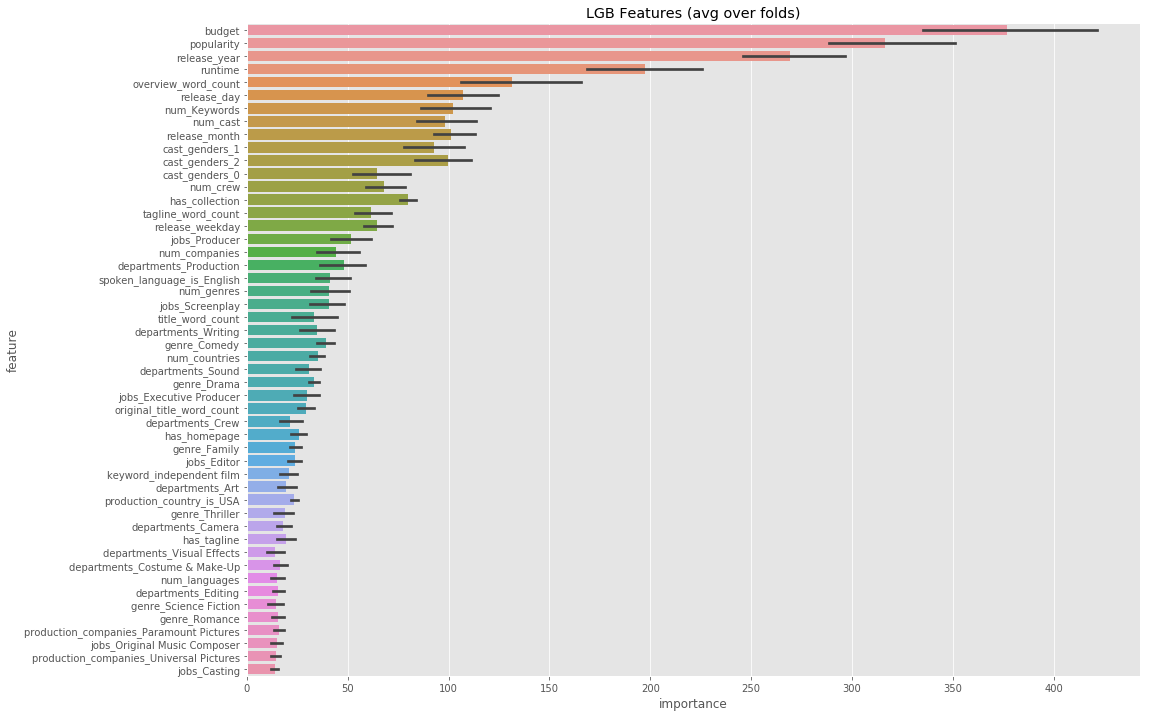

In [54]:
warnings.simplefilter('ignore')
oof_lgb_1, prediction_lgb_1, _ = train_model(X, X_test, y, params=lgb_params, model_type='lgb', plot_feature_importance=True)

**Cat Boost**

In [55]:
oof_cb_1, prediction_cb_1  = train_model(X, X_test, y, params=cb_params, model_type='cb', plot_feature_importance=False)

Fold 0 started at Thu Mar 21 08:55:04 2019
Fold 1 started at Thu Mar 21 08:55:22 2019
Fold 2 started at Thu Mar 21 08:55:42 2019
Fold 3 started at Thu Mar 21 08:56:00 2019
Fold 4 started at Thu Mar 21 08:56:15 2019
CV mean score: 1.7358, std: 0.1252.


#### Additional Feature Engineering.

Since in all three models budget, popularity, release year and runtime appear to be the important predictors we create additional features to capture interactions between these variables.

In [56]:
def prepare(df):
    df['_budget_runtime_ratio'] = df['budget']/df['runtime'] 
    df['_budget_popularity_ratio'] = df['budget']/df['popularity']
    df['_budget_year_ratio'] = df['budget']/(df['release_year']*df['release_year'])
    df['_releaseYear_popularity_ratio'] = df['release_year']/df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity']/df['release_year']
    df['_year_to_log_budget'] = df['release_year'] / np.log1p(df['budget'])
    df['_year_to_log_popularity'] = df['release_year'] / np.log1p(df['popularity'])
    df['runtime_to_mean_year'] = df['runtime'] / df.groupby("release_year")["runtime"].transform('mean')
    df['popularity_to_mean_year'] = df['popularity'] / df.groupby("release_year")["popularity"].transform('mean')
    df['budget_to_mean_year'] = df['budget'] / df.groupby("release_year")["budget"].transform('mean')
    
    return df
X_new = prepare(X)
X_test_new = prepare(X_test)

In [57]:
X_new.head()

,budget,popularity,runtime,release_year,release_month,release_day,release_weekday,release_quarter,has_collection,num_genres,...,_budget_runtime_ratio,_budget_popularity_ratio,_budget_year_ratio,_releaseYear_popularity_ratio,_releaseYear_popularity_ratio2,_year_to_log_budget,_year_to_log_popularity,runtime_to_mean_year,popularity_to_mean_year,budget_to_mean_year
0,14000000.0,6.575393,93.0,2015,2,20,4,1,1,1,...,150537.634409,2.129150e+06,3.448085,306.445562,0.003263,122.458396,995.108299,0.830821,0.642915,0.435821
1,40000000.0,8.248895,113.0,2004,8,6,4,3,1,4,...,353982.300885,4.849134e+06,9.960120,242.941630,0.004116,114.485566,900.874947,1.075080,0.984041,1.184914
2,3300000.0,64.299990,105.0,2014,10,10,4,4,0,1,...,31428.571429,5.132194e+04,0.813570,31.321933,0.031927,134.182281,481.934413,0.980340,6.073148,0.126059
3,1200000.0,3.174936,122.0,2012,3,9,4,1,0,2,...,9836.065574,3.779604e+05,0.296432,633.713561,0.001578,143.736535,1407.880041,1.133745,0.387724,0.039887
4,8000000.0,1.148070,118.0,2009,2,5,3,1,0,2,...,67796.610169,6.968216e+06,1.982121,1749.893299,0.000571,126.392327,2627.621563,1.107001,0.145631,0.318859


In [51]:
X_new_train, X_new_valid, y_train, y_valid = train_test_split(X_new, y, test_size=0.2, random_state = 42)

**Modelling with addditional features**

In [49]:
xgb_params = {'learning_rate': 0.01,
              'objective': 'reg:linear',
              'max_depth': 5,
              'gamma' : 0,
              'min_child_weight': 3,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}

xgb_model_2 = xgb.XGBRegressor(**xgb_params, n_estimators = 10000, n_jobs = 4)
xgb_model_2.fit(X_new_train, y_train, 
        eval_set=[(X_new_train, y_train), (X_new_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)


[0]	validation_0-rmse:15.644	validation_1-rmse:15.7904
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 200 rounds.
[1000]	validation_0-rmse:0.986168	validation_1-rmse:1.74235
Stopping. Best iteration:
[1375]	validation_0-rmse:0.835864	validation_1-rmse:1.73437



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='rmse', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=3, missing=None, n_estimators=10000, n_jobs=4,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=11, silent=True,
       subsample=0.8)

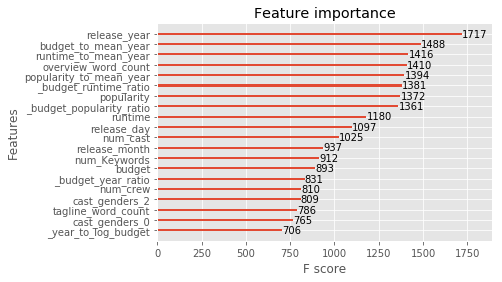

In [52]:
xgb.plot_importance(xgb_model_2, max_num_features = 20)

In [50]:
lgb_params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         #"feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse'}
         #"lambda_l1": 0.2,
         #"verbosity": -1}

lgb_model_2 = lgb.LGBMRegressor(**lgb_params, n_estimators = 10000, n_jobs = 4)

lgb_model_2.fit(X_new_train, y_train, 
        eval_set=[(X_new_train, y_train), (X_new_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.13664	valid_1's rmse: 1.76775
Early stopping, best iteration is:
[984]	training's rmse: 1.14294	valid_1's rmse: 1.76744


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
       boosting='gbdt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
       max_depth=5, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
       n_estimators=10000, n_jobs=4, num_leaves=30, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

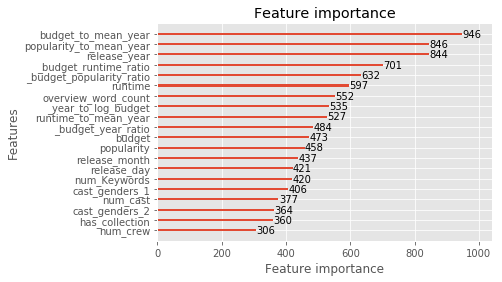

In [54]:
lgb.plot_importance(lgb_model_2, max_num_features = 20)

In [62]:
cb_params = {'learning_rate': 0.02,
              'depth': 5,
              'l2_leaf_reg': 10,
              'bootstrap_type': 'Bernoulli',
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 50,
              'random_seed': 11,
              'allow_writing_files': False}
cb_model_2 = cb.CatBoostRegressor(iterations=10000, eval_metric='RMSE', **cb_params)

cb_model_2.fit(X_new_train, y_train, eval_set=[(X_new_train, y_train),(X_new_valid, y_valid)], cat_features=[], use_best_model=True, verbose=False)

print("RMSE on training data: "+ cb_model_2.score(X_new_train, y_train).astype(str))
print("RMSE on validation data: "+ cb_model_2.score(X_new_valid, y_valid).astype(str))

RMSE on training data: 1.3200531646710496
RMSE on validation data: 1.7238455752053259


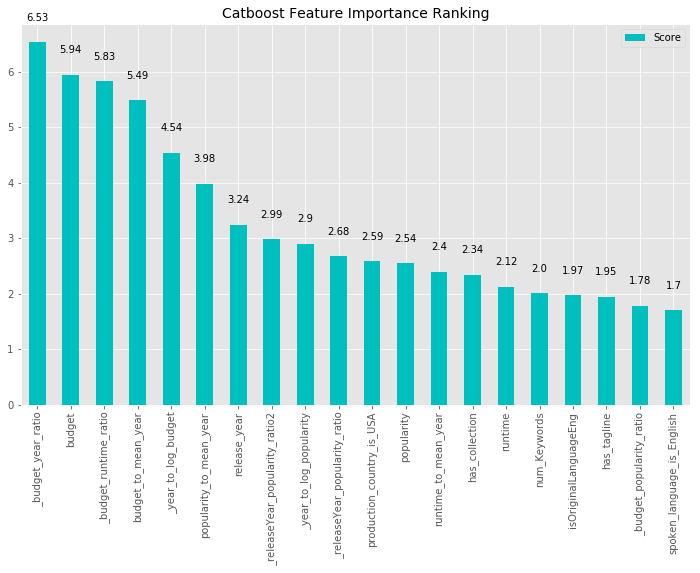

In [56]:
feature_score = pd.DataFrame(list(zip(X_new.dtypes.index,cb_model_2.get_feature_importance(cb.Pool(X_new, label=y, cat_features=[])))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')[:20]

plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

#### Kfold cross validation and prediction for each model with additional features

In [58]:

oof_xgb_2, prediction_xgb_2 = train_model(X_new, X_test_new, y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Thu Mar 21 11:23:04 2019
[0]	train-rmse:15.6442	valid_data-rmse:15.7906
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.25124	valid_data-rmse:1.76907
[1000]	train-rmse:0.973723	valid_data-rmse:1.73706
Stopping. Best iteration:
[1139]	train-rmse:0.914794	valid_data-rmse:1.73383

Fold 1 started at Thu Mar 21 11:23:57 2019
[0]	train-rmse:15.6875	valid_data-rmse:15.6209
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.28296	valid_data-rmse:1.68145
[1000]	train-rmse:1.00553	valid_data-rmse:1.65288
[1500]	train-rmse:0.806411	valid_data-rmse:1.64783
Stopping. Best iteration:
[1710]	train-rmse:0.734936	valid_data-rmse:1.64567

Fold 2 started at Thu Mar 21 11:25:12 2019
[0]	train-rmse:15.6787	valid_data-rmse:15.6558
Multiple eva

Fold 0 started at Thu Mar 21 11:28:22 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.13072	valid_1's rmse: 1.77838
Early stopping, best iteration is:
[1260]	training's rmse: 1.04637	valid_1's rmse: 1.77702
Fold 1 started at Thu Mar 21 11:28:30 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.15449	valid_1's rmse: 1.68097
Early stopping, best iteration is:
[1530]	training's rmse: 0.98124	valid_1's rmse: 1.67685
Fold 2 started at Thu Mar 21 11:28:38 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.15351	valid_1's rmse: 1.60789
Early stopping, best iteration is:
[808]	training's rmse: 1.22906	valid_1's rmse: 1.60518
Fold 3 started at Thu Mar 21 11:28:43 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.07334	valid_1's rmse: 1.93941
Early stopping, best iteration is:
[1219]	training's rmse: 0.997648	valid_1's rm

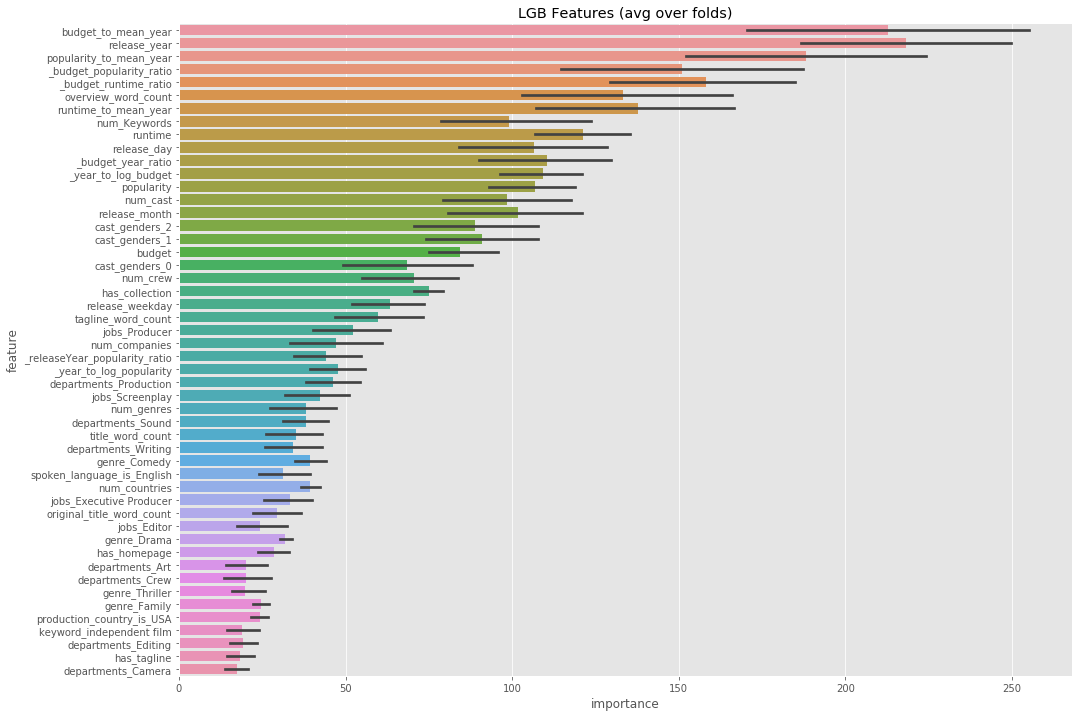

In [59]:
warnings.simplefilter('ignore')
oof_lgb_2, prediction_lgb_2,_ = train_model(X_new, X_test_new, y, params=lgb_params, model_type='lgb', plot_feature_importance=True)

In [60]:
oof_cb_2, prediction_cb_2 = train_model(X_new, X_test_new, y, params=cb_params, model_type='cb', plot_feature_importance=False)

Fold 0 started at Thu Mar 21 11:29:19 2019
Fold 1 started at Thu Mar 21 11:29:48 2019
Fold 2 started at Thu Mar 21 11:30:16 2019
Fold 3 started at Thu Mar 21 11:30:45 2019
Fold 4 started at Thu Mar 21 11:31:12 2019
CV mean score: 1.7348, std: 0.1251.


We will now look at some parameter tuning to see if the scores improve further.

**Hyperparameter tuning** 

For  each estimator we will tune the parameters that are likely to have the maximum impact on the outcome.

**XGBoost Hyperparameter tuning** 

In [52]:
train_data = xgb.DMatrix(X_new_train, label=y_train)
valid_data = xgb.DMatrix(X_new_valid, label = y_valid)

watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
model = xgb.train(dtrain = train_data, num_boost_round=10000, evals=watchlist, early_stopping_rounds=200, 
                  verbose_eval=500, params=xgb_params)



[0]	train-rmse:15.644	valid_data-rmse:15.7904
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.25473	valid_data-rmse:1.77337
[1000]	train-rmse:0.986168	valid_data-rmse:1.74235
[1500]	train-rmse:0.789582	valid_data-rmse:1.73522
Stopping. Best iteration:
[1375]	train-rmse:0.835864	valid_data-rmse:1.73437



In [50]:
xgb_params = {'learning_rate': 0.01,
              'objective': 'reg:linear',
              'max_depth': 5,
              'gamma' : 0,
              'min_child_weight': 3,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3,10,2)
    for min_child_weight in range(1,6,2)
]


In [ ]:

# Define initial best params and MAE
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    xgb_params['max_depth'] = max_depth
    xgb_params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        xgb_params,
        dtrain = train_data,
        num_boost_round=2000,
        seed=42,
        nfold=3,
        early_stopping_rounds=200,
        verbose_eval = 100
    )
    # Update best RMSE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)


In [57]:
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

Best params: 5, 1, RMSE: 1.7289673333333333


In [61]:
xgb_params['max_depth'] = 5
xgb_params['min_child_weight'] = 1

**Light GBM Hyperparameter Tuning**

In [54]:
lgb_params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         #"feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse'}

Grid_Search_Params ={
    "max_depth": [4,5,6],
    #"min_data_in_leaf": [15,20,25],
    "num_leaves": [15,30,40, 50]
    }

In [ ]:

grid_search = GridSearchCV(
    estimator=lgb_model_2, 
    param_grid= Grid_Search_Params, 
    refit=True,
    verbose=100)

grid_search.fit(X_new_train, y_train)


In [61]:
print('Best score reached: {} with lgb params: {} '.format(grid_search.best_score_, grid_search.best_params_))

Best score reached: 0.5396986830994575 with lgb params: {'max_depth': 6, 'num_leaves': 30} 


In [62]:

lgb_params['num_leaves'] = 30
lgb_params['max_depth'] = 6

In [56]:
cb_search_params = {'learning_rate': 0.02,
              'depth': [4,5,6,7],
              'l2_leaf_reg': [5,10],
              'bootstrap_type': 'Bernoulli',
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 50,
              'random_seed': 11,
              'allow_writing_files': False}


In [57]:
# this function does 3-fold crossvalidation with catboostregressor          
def crossvaltest(params,train_set,train_label,n_splits=3):
    kf = KFold(n_splits=n_splits,shuffle=True, random_state = 42) 
    res = []
    for fold_n, (train_index, valid_index) in enumerate(kf.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        
        X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        clf = cb.CatBoostRegressor(iterations=2000, eval_metric='RMSE', **params)
        clf.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_valid, y_valid)],cat_features=[], use_best_model=True, verbose=False)

        res.append(mean_squared_error(clf.predict(X_valid), y_valid)**0.5)
    return np.mean(res)


In [58]:
# this function runs grid search on several parameters
def catboost_param_tune(params,train_set,train_label,n_splits=3):
    ps = paramsearch(params)
    for prms in ps.grid_search(['depth','l2_leaf_reg']):
        res = crossvaltest(prms,train_set,train_label, n_splits)
        # save the crossvalidation result so that future iterations can reuse the best parameters
        ps.register_result(res,prms)
        print(res,prms,'best:', ps.bestscore(),ps.bestparam())
    #print(ps.bestscore(), ps.bestparam())
    return ps.bestparam()

In [59]:
bestparams = catboost_param_tune(cb_search_params,X_new_train,y_train)

Fold 0 started at Wed Mar 20 12:55:17 2019
Fold 1 started at Wed Mar 20 12:55:38 2019
Fold 2 started at Wed Mar 20 12:55:56 2019
1.7181587390203255 {'learning_rate': 0.02, 'depth': 4, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli', 'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False} best: 1.718158738801817 {'learning_rate': 0.02, 'depth': 4, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli', 'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
Fold 0 started at Wed Mar 20 12:56:09 2019
Fold 1 started at Wed Mar 20 12:56:30 2019
Fold 2 started at Wed Mar 20 12:56:59 2019
1.7169427635655017 {'learning_rate': 0.02, 'depth': 5, 'l2_leaf_reg': 5, 'bootstrap_type': 'Bernoulli', 'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False} best: 1.71694276375019 {'learning_rate': 0.02, 'depth': 5, 'l2_leaf_reg': 5, 'bootstrap_type': 'Bernoulli', 'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writin

In [60]:
print(bestparams)

{'learning_rate': 0.02, 'depth': 5, 'l2_leaf_reg': 5, 'bootstrap_type': 'Bernoulli', 'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}


In [63]:
cb_params['depth'] = 5
cb_params['l2_leaf_reg'] = 5

**K-fold validation and predictions with tuned parameters**


In [64]:
oof_xgb_3, prediction_xgb_3 = train_model(X_new, X_test_new, y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Thu Mar 21 11:32:48 2019
[0]	train-rmse:15.6442	valid_data-rmse:15.7905
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.23342	valid_data-rmse:1.77418
[1000]	train-rmse:0.950416	valid_data-rmse:1.74168
[1500]	train-rmse:0.760982	valid_data-rmse:1.73575
Stopping. Best iteration:
[1724]	train-rmse:0.690192	valid_data-rmse:1.73348

Fold 1 started at Thu Mar 21 11:34:05 2019
[0]	train-rmse:15.6876	valid_data-rmse:15.6207
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.25528	valid_data-rmse:1.68765
[1000]	train-rmse:0.979893	valid_data-rmse:1.65502
[1500]	train-rmse:0.78606	valid_data-rmse:1.64996
Stopping. Best iteration:
[1700]	train-rmse:0.718769	valid_data-rmse:1.64763

Fold 2 started at Thu Mar 21 11:35:20 2019
[0]	trai

In [65]:
oof_lgb_3, prediction_lgb_3 = train_model(X_new, X_test_new, y, params=lgb_params, model_type='lgb', plot_feature_importance=False)

Fold 0 started at Thu Mar 21 11:38:50 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.998533	valid_1's rmse: 1.77596
Early stopping, best iteration is:
[860]	training's rmse: 1.05559	valid_1's rmse: 1.77534
Fold 1 started at Thu Mar 21 11:38:57 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.01818	valid_1's rmse: 1.67964
Early stopping, best iteration is:
[1368]	training's rmse: 0.88146	valid_1's rmse: 1.67589
Fold 2 started at Thu Mar 21 11:39:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[766]	training's rmse: 1.11731	valid_1's rmse: 1.61643
Fold 3 started at Thu Mar 21 11:39:12 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.939976	valid_1's rmse: 1.943
Early stopping, best iteration is:
[1060]	training's rmse: 0.917102	valid_1's rmse: 1.94226
Fold 4 started at Thu Mar 21 11:39:20 2019
Tr

In [66]:
oof_cb_3, prediction_cb_3 = train_model(X_new, X_test_new, y, params=cb_params, model_type='cb', plot_feature_importance=False)

Fold 0 started at Thu Mar 21 11:39:48 2019
Fold 1 started at Thu Mar 21 11:40:28 2019
Fold 2 started at Thu Mar 21 11:40:53 2019
Fold 3 started at Thu Mar 21 11:41:18 2019
Fold 4 started at Thu Mar 21 11:41:43 2019
CV mean score: 1.7264, std: 0.1232.


**Kaggle Submission Files**

In [67]:
submission = pd.read_csv('data/sample_submission.csv')
submission['id'] = test_id

**Stacked Average Prediction of XGBoost, Light GBM, CatBoost first models**

In [75]:
submission['revenue'] = np.expm1((prediction_xgb_1 + prediction_lgb_1 + prediction_cb_1)/3)
submission.to_csv("blended_1.csv", index = False)

**Stacked Average Prediction of XGBoost, Light GBM, CatBoost second models with additional features**

In [92]:
submission['revenue'] = np.expm1((prediction_xgb_2 + prediction_lgb_2 + prediction_cb_2)/3)
submission.to_csv("blended_2.csv", index = False)


**Stacked Average Prediction of XGBoost, Light GBM, CatBoost third models with parameter tuning**

In [68]:
submission['revenue'] = np.expm1((prediction_xgb_3 + prediction_lgb_3 + prediction_cb_3)/3)
submission.to_csv("blended_3.csv", index = False)